 
# NPS

NPS implements a non-parametric polygenic risk prediction algorithm. NPS transforms genetic data into an orthogonal domain called "eigenlocus space". Then, it re-weights GWAS effect sizes by partitioning genetic variations into trenches and measuring the predictive power of each trench in an independent training cohort.

## Installation

```bash
https://github.com/sgchun/nps
wget https://github.com/sgchun/nps/archive/1.1.1.tar.gz
tar -zxvf  1.1.1.tar.gz
cd nps-1.1.1/
make .
```

Copy the files in `nps-1.1.1` into the current working directory. It ensures smooth execution, as some code files rely on bash files from NPS, and placing the files in the current directory helps with execution.

## Genotype and GWAS Data Processing

NPS requires both GWAS and genotype data in a specific format. Genotype data should be in a `dosage.gz` file, and you may need `qctool` ([documentation](https://www.chg.ox.ac.uk/~gav/qctool_v2/documentation/download.html)) to process the information.

1. Genotype data was processed using the following quality controls:
   ```python
   command = [
       "./plink",
       "--maf", str(0.2),
       "--geno", str(0.001),
       "--hwe", str(0.00001),
       "--bfile", traindirec + os.sep + newtrainfilename,
       "--indep-pairwise", p1_val, p2_val, p3_val,
       "--out", traindirec + os.sep + trainfilename
   ]
   subprocess.run(command)
   ```
   
2. The number of SNPs in the GWAS and genotype data should be the same, with no missing values or `NA` in the genotype data.

3. The name of the genotype data (train/test) should follow specific prefixes; otherwise, it may not work as it is a bash-based tool and can be difficult to troubleshoot.

4. Genotype data for all chromosomes should be present, or the GWAS tool may crash as it runs for all chromosomes.

## Hyperparameter  

NPS considers multiple hyperparameters. One of the hyperparameters we considered is the window size, and new betas are generated for each window size.


## Train/Testing sets

NPS generates multiple sets of betas. We used these betas and calculated the PRS using Plink, but one can also use the default method provided by NPS to calculate the performance for the test set.



## Input files for NPS

**Taken from NPS documentation.**



To run NPS, you need the following set of files: 

1. **GWAS summary statistics.** This is a *tab-delimited* text file format with the following seven required columns: 
     - **chr**: chromosome name starting with "chr." Currently, NPS expects only chromosomes 1-22. Chromosome names should be designated by "chr1", ..., "chr22".
     - **pos**: base position of SNP.
     - **ref** and **alt**: reference and alternative alleles of SNP, respectively.
     - **reffreq**: allele frequency of reference allele in the discovery GWAS cohort. 
     - **pval**: p-value of association. 
     - **effalt**: estimated *per-allele* effect size of *the alternative allele*. For case/control GWAS, log(Odds Ratio) should be used. NPS will convert **effalt** to effect sizes relative to *the standardized genotype* internally using **reffreq**.  
     ```
     chr        pos     ref     alt     reffreq pval    effalt
     chr1       11008   C       G       0.9041  0.1126  -0.0251
     chr1       11012   C       G       0.9041  0.1126  -0.0251
     chr1       13116   T       G       0.8307  0.615   0.0071
     chr1       13118   A       G       0.8307  0.615   0.0071
     chr1       14464   A       T       0.8386  0.476   -0.0105
     ...
     ```

2. **Training genotype files.** Training genotype files should be in the qctool dosage format and named as "chrom*N*.*DatasetID*.dosage.gz" for each chromosome. Genotype files in bgen format can be converted to the dosage files by running [qctool](https://www.well.ox.ac.uk/~gav/qctool_v2/documentation/examples/converting.html) with the `-ofiletype dosage` option. NPS allows only *biallelic* variants. 
   
3. **Training sample file (.fam).** Sample information of training cohort should be provided in [PLINK FAM format](https://www.cog-genomics.org/plink2/formats#fam). The samples in the .fam file should appear in the exactly same order as in the genotype dosage files. The sex of sample (5-th column) is optional ("0" or "-9" for missing; "1" for male; "2" for female). If the sex is provided, NPS will incorporate the sex covariate in the PRS model. The 6-th column is for phenotype data and can be specified here or in a separeate phenotype file. 
   ```
   trainF2  trainI2  0  0  1 -9
   trainF3  trainI3  0  0  2 -9
   trainF39 trainI39 0  0  1 -9
   trainF41 trainI41 0  0  2 -9
   trainF58 trainI58 0  0  1 -9
   ```
4. **Training phenotype file (.phen).** Phenotypes of the .fam file can be overridden by a .phen file (use `nps_init.R --train-phen` option). This is a tab-delimited file with three columns: "FID", "IID", and "Outcome". FID and IID correspond to the family and individual IDs in the .fam file. The name of phenotype should be "Outcome". Binary phenotypes (case/control) are specified by "1" and "2", respectively; "0" and "-9" denote missing phenotype. For quantitative phenotypes, "-9" represents a missing phenotype value. 
   ```
   FID   IID    Outcome
   trainF2  trainI2  1
   trainF39 trainI39 1
   trainF3  trainI3  2
   trainF41 trainI41 2
   trainF58 trainI58 1
   ```
5. **Validation genotype files.** Validation genotypes can be in the dosage or .bgen format. If they are in .bgen format, the files should be named as "chrom*N*.*DatasetID*.bgen". 

6. **Validation sample file (.fam).** Similar to the training .fam file. 

7. **Training phenotype file (.phen).** Similar to training .phen file. 

## GWAS File Processing for NPS

When the effect size relates to disease risk and is given as an odds ratio (OR) rather than BETA (for continuous traits), the polygenic risk score (PRS) is computed as a product of ORs. To simplify this calculation, take the natural logarithm of the OR so that the PRS can be computed using summation instead.

We will modify the GWAS accordingly. NPS requires modifying the GWAS in a particular format, and we modified it when calculating PRS using NPS.




In [1]:
import os
import pandas as pd
import numpy as np
import sys

#filedirec = sys.argv[1]

filedirec = "SampleData1"
 
#filedirec = "migraine_0"

def check_phenotype_is_binary_or_continous(filedirec):
    # Read the processed quality controlled file for a phenotype
    df = pd.read_csv(filedirec+os.sep+filedirec+'_QC.fam',sep="\s+",header=None)
    column_values = df[5].unique()
 
    if len(set(column_values)) == 2:
        return "Binary"
    else:
        return "Continous"

# Read the GWAS file.
GWAS = "./"+filedirec + os.sep + filedirec+".gz"
df = pd.read_csv(GWAS,compression= "gzip",sep="\s+")

if check_phenotype_is_binary_or_continous(filedirec)=="Binary":
    if "BETA" in df.columns.to_list():
        # For Binary Phenotypes.
        df["OR"] = np.exp(df["BETA"])
        df = df[['CHR', 'BP', 'SNP', 'A1', 'A2', 'N', 'SE', 'P', 'OR', 'INFO', 'MAF']]
 
    else:
        # For Binary Phenotype.
        df = df[['CHR', 'BP', 'SNP', 'A1', 'A2', 'N', 'SE', 'P', 'OR', 'INFO', 'MAF']]
 
elif check_phenotype_is_binary_or_continous(filedirec)=="Continous":
    if "BETA" in df.columns.to_list():
        # For Continous Phenotype.
        df = df[['CHR', 'BP', 'SNP', 'A1', 'A2', 'N', 'SE', 'P', 'BETA', 'INFO', 'MAF']]

    else:
        df["BETA"] = np.log(df["OR"])
        df = df[['CHR', 'BP', 'SNP', 'A1', 'A2', 'N', 'SE', 'P', 'BETA', 'INFO', 'MAF']]


df.to_csv(filedirec + os.sep +filedirec+"_NPS.txt",sep="\t",index=False)
print(df.head().to_markdown())
print("Length of DataFrame!",len(df))

df.to_csv(filedirec + os.sep +filedirec+"_NPS.gz", index=False,sep="\t",compression='gzip')


FileNotFoundError: [Errno 2] No such file or directory: './SampleData1\\SampleData1.gz'

### Define Hyperparameters

Define hyperparameters to be optimized and set initial values.

### Extract Valid SNPs from Clumped File

For Windows, download `gwak`, and for Linux, the `awk` command is sufficient. For Windows, `GWAK` is required. You can download it from [here](https://sourceforge.net/projects/gnuwin32/). Get it and place it in the same directory.


### Execution Path

At this stage, we have the genotype training data `newtrainfilename = "train_data.QC"` and genotype test data `newtestfilename = "test_data.QC"`.

We modified the following variables:

1. `filedirec = "SampleData1"` or `filedirec = sys.argv[1]`
2. `foldnumber = "0"` or `foldnumber = sys.argv[2]` for HPC.

Only these two variables can be modified to execute the code for specific data and specific folds. Though the code can be executed separately for each fold on HPC and separately for each dataset, it is recommended to execute it for multiple diseases and one fold at a time.
Here’s the corrected text in Markdown format:

 
### P-values

PRS calculation relies on P-values. SNPs with low P-values, indicating a high degree of association with a specific trait, are considered for calculation.

You can modify the code below to consider a specific set of P-values and save the file in the same format.

We considered the following parameters:

- **Minimum P-value**: `1e-10`
- **Maximum P-value**: `1.0`
- **Minimum exponent**: `10`  (Minimum P-value in exponent)
- **Number of intervals**: `100`  (Number of intervals to be considered)

The code generates an array of logarithmically spaced P-values:

```python
import numpy as np
import os

minimumpvalue = 10  # Minimum exponent for P-values
numberofintervals = 100  # Number of intervals to be considered

allpvalues = np.logspace(-minimumpvalue, 0, numberofintervals, endpoint=True)  # Generating an array of logarithmically spaced P-values

print("Minimum P-value:", allpvalues[0])
print("Maximum P-value:", allpvalues[-1])

count = 1
with open(os.path.join(folddirec, 'range_list'), 'w') as file:
    for value in allpvalues:
        file.write(f'pv_{value} 0 {value}\n')  # Writing range information to the 'range_list' file
        count += 1

pvaluefile = os.path.join(folddirec, 'range_list')
```

In this code:
- `minimumpvalue` defines the minimum exponent for P-values.
- `numberofintervals` specifies how many intervals to consider.
- `allpvalues` generates an array of P-values spaced logarithmically.
- The script writes these P-values to a file named `range_list` in the specified directory.
 

In [10]:
from operator import index
import pandas as pd
import numpy as np
import os
import subprocess
import sys
import pandas as pd
import statsmodels.api as sm
import pandas as pd
from sklearn.metrics import roc_auc_score, confusion_matrix
from statsmodels.stats.contingency_tables import mcnemar

def create_directory(directory):
    """Function to create a directory if it doesn't exist."""
    if not os.path.exists(directory):  # Checking if the directory doesn't exist
        os.makedirs(directory)  # Creating the directory if it doesn't exist
    return directory  # Returning the created or existing directory

 
#foldnumber = sys.argv[1]
foldnumber = "0"  # Setting 'foldnumber' to "0"

folddirec = filedirec + os.sep + "Fold_" + foldnumber  # Creating a directory path for the specific fold
trainfilename = "train_data"  # Setting the name of the training data file
newtrainfilename = "train_data.QC"  # Setting the name of the new training data file

testfilename = "test_data"  # Setting the name of the test data file
newtestfilename = "test_data.QC"  # Setting the name of the new test data file

# Number of PCA to be included as a covariate.
numberofpca = ["6"]  # Setting the number of PCA components to be included

# Clumping parameters.
clump_p1 = [1]  # List containing clump parameter 'p1'
clump_r2 = [0.1]  # List containing clump parameter 'r2'
clump_kb = [200]  # List containing clump parameter 'kb'

# Pruning parameters.
p_window_size = [200]  # List containing pruning parameter 'window_size'
p_slide_size = [50]  # List containing pruning parameter 'slide_size'
p_LD_threshold = [0.25]  # List containing pruning parameter 'LD_threshold'

# Kindly note that the number of p-values to be considered varies, and the actual p-value depends on the dataset as well.
# We will specify the range list here.

minimumpvalue = 10  # Minimum p-value in exponent
numberofintervals = 20  # Number of intervals to be considered
allpvalues = np.logspace(-minimumpvalue, 0, numberofintervals, endpoint=True)  # Generating an array of logarithmically spaced p-values



count = 1
with open(folddirec + os.sep + 'range_list', 'w') as file:
    for value in allpvalues:
        file.write(f'pv_{value} 0 {value}\n')  # Writing range information to the 'range_list' file
        count = count + 1

pvaluefile = folddirec + os.sep + 'range_list'

# Initializing an empty DataFrame with specified column names
prs_result = pd.DataFrame(columns=["clump_p1", "clump_r2", "clump_kb", "p_window_size", "p_slide_size", "p_LD_threshold",
                                   "pvalue", "numberofpca","numberofvariants","Train_pure_prs", "Train_null_model", "Train_best_model",
                                   "Test_pure_prs", "Test_null_model", "Test_best_model"])

### Define Helper Functions

1. **Perform Clumping and Pruning**
2. **Calculate PCA Using Plink**
3. **Fit Binary Phenotype and Save Results**
4. **Fit Continuous Phenotype and Save Results**


In [11]:
import os
import subprocess
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import explained_variance_score


def perform_clumping_and_pruning_on_individual_data(traindirec, newtrainfilename,numberofpca, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile):
    
    # Perform additional quality controls for NPS.
    #    "--maf",str(0.2),
    #    "--geno",str(0.001),
    #    "--hwe",str(0.00001),
    
    command = [
    "./plink",
    "--maf",str(0.2),
    "--geno",str(0.001),
    "--hwe",str(0.00001),
    "--bfile", traindirec+os.sep+newtrainfilename,
    "--indep-pairwise", p1_val, p2_val, p3_val,
    "--out", traindirec+os.sep+trainfilename
    ]
    subprocess.run(command)
    # First perform pruning and then clumping and the pruning.

    command = [
    "./plink",
    "--bfile", traindirec+os.sep+newtrainfilename,
    "--clump-p1", c1_val,
    "--extract", traindirec+os.sep+trainfilename+".prune.in",
    "--clump-r2", c2_val,
    "--clump-kb", c3_val,
    "--clump", filedirec+os.sep+filedirec+".txt",
    "--clump-snp-field", "SNP",
    "--clump-field", "P",
    "--out", traindirec+os.sep+trainfilename
    ]    
    subprocess.run(command)

    # Extract the valid SNPs from th clumped file.
    # For windows download gwak for linux awk commmand is sufficient.
    ### For windows require GWAK.
    ### https://sourceforge.net/projects/gnuwin32/
    ##3 Get it and place it in the same direc.
    #os.system("gawk "+"\""+"NR!=1{print $3}"+"\"  "+ traindirec+os.sep+trainfilename+".clumped >  "+traindirec+os.sep+trainfilename+".valid.snp")
    #print("gawk "+"\""+"NR!=1{print $3}"+"\"  "+ traindirec+os.sep+trainfilename+".clumped >  "+traindirec+os.sep+trainfilename+".valid.snp")

    #Linux:
 
    command = f"awk 'NR!=1{{print $3}}' {traindirec}{os.sep}{trainfilename}.clumped > {traindirec}{os.sep}{trainfilename}.valid.snp"
    os.system(command)
    
    command = [
    "./plink",
    "--make-bed",
    "--bfile", traindirec+os.sep+newtrainfilename,
    "--indep-pairwise", p1_val, p2_val, p3_val,
    "--extract", traindirec+os.sep+trainfilename+".valid.snp",
    "--out", traindirec+os.sep+newtrainfilename+".clumped.pruned"
    ]
    subprocess.run(command)
    
    command = [
    "./plink",
    "--make-bed",
    "--bfile", traindirec+os.sep+testfilename,
    "--indep-pairwise", p1_val, p2_val, p3_val,
    "--extract", traindirec+os.sep+trainfilename+".valid.snp",
    "--out", traindirec+os.sep+testfilename+".clumped.pruned"
    ]
    subprocess.run(command)    
    
    
 
def calculate_pca_for_traindata_testdata_for_clumped_pruned_snps(traindirec, newtrainfilename,p):
    
    # Calculate the PRS for the test data using the same set of SNPs and also calculate the PCA.


    # Also extract the PCA at this point.
    # PCA are calculated afer clumping and pruining.
    command = [
        "./plink",
        "--bfile", folddirec+os.sep+testfilename+".clumped.pruned",
        # Select the final variants after clumping and pruning.
        "--extract", traindirec+os.sep+trainfilename+".valid.snp",
        "--pca", p,
        "--out", folddirec+os.sep+testfilename
    ]
    subprocess.run(command)


    command = [
    "./plink",
        "--bfile", traindirec+os.sep+newtrainfilename+".clumped.pruned",
        # Select the final variants after clumping and pruning.        
        "--extract", traindirec+os.sep+trainfilename+".valid.snp",
        "--pca", p,
        "--out", traindirec+os.sep+trainfilename
    ]
    subprocess.run(command)

# This function fit the binary model on the PRS.
def fit_binary_phenotype_on_PRS(traindirec, newtrainfilename,p,window_shift, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile):
    threshold_values = allpvalues

    # Merge the covariates, pca and phenotypes.
    tempphenotype_train = pd.read_table(traindirec+os.sep+newtrainfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype_train = pd.DataFrame()
    phenotype_train["Phenotype"] = tempphenotype_train[5].values
    pcs_train = pd.read_table(traindirec+os.sep+trainfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_train = pd.read_table(traindirec+os.sep+trainfilename+".cov",sep="\s+")
    covariate_train.fillna(0, inplace=True)
    covariate_train = covariate_train[covariate_train["FID"].isin(pcs_train["FID"].values) & covariate_train["IID"].isin(pcs_train["IID"].values)]
    covariate_train['FID'] = covariate_train['FID'].astype(str)
    pcs_train['FID'] = pcs_train['FID'].astype(str)
    covariate_train['IID'] = covariate_train['IID'].astype(str)
    pcs_train['IID'] = pcs_train['IID'].astype(str)
    covandpcs_train = pd.merge(covariate_train, pcs_train, on=["FID","IID"])
    covandpcs_train.fillna(0, inplace=True)


    ## Scale the covariates!
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import explained_variance_score
    scaler = MinMaxScaler()
    normalized_values_train = scaler.fit_transform(covandpcs_train.iloc[:, 2:])
    #covandpcs_train.iloc[:, 2:] = normalized_values_test 
    
    
    tempphenotype_test = pd.read_table(traindirec+os.sep+testfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype_test= pd.DataFrame()
    phenotype_test["Phenotype"] = tempphenotype_test[5].values
    pcs_test = pd.read_table(traindirec+os.sep+testfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_test = pd.read_table(traindirec+os.sep+testfilename+".cov",sep="\s+")
    covariate_test.fillna(0, inplace=True)
    covariate_test = covariate_test[covariate_test["FID"].isin(pcs_test["FID"].values) & covariate_test["IID"].isin(pcs_test["IID"].values)]
    covariate_test['FID'] = covariate_test['FID'].astype(str)
    pcs_test['FID'] = pcs_test['FID'].astype(str)
    covariate_test['IID'] = covariate_test['IID'].astype(str)
    pcs_test['IID'] = pcs_test['IID'].astype(str)
    covandpcs_test = pd.merge(covariate_test, pcs_test, on=["FID","IID"])
    covandpcs_test.fillna(0, inplace=True)
    normalized_values_test  = scaler.transform(covandpcs_test.iloc[:, 2:])
    #covandpcs_test.iloc[:, 2:] = normalized_values_test     
    
    
    
    
    tempalphas = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    l1weights = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

    tempalphas = [0.1]
    l1weights = [0.1]

    phenotype_train["Phenotype"] = phenotype_train["Phenotype"].replace({1: 0, 2: 1}) 
    phenotype_test["Phenotype"] = phenotype_test["Phenotype"].replace({1: 0, 2: 1})
      
    for tempalpha in tempalphas:
        for l1weight in l1weights:

            
            try:
                null_model =  sm.Logit(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit_regularized(alpha=tempalpha, L1_wt=l1weight)
                #null_model =  sm.Logit(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit()
            
            except:
                print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
                continue

            train_null_predicted = null_model.predict(sm.add_constant(covandpcs_train.iloc[:, 2:]))
            
            from sklearn.metrics import roc_auc_score, confusion_matrix
            from sklearn.metrics import r2_score
            
            test_null_predicted = null_model.predict(sm.add_constant(covandpcs_test.iloc[:, 2:]))
            
           
            
            global prs_result 
            for i in threshold_values:
                try:
                    prs_train = pd.read_table(traindirec+os.sep+Name+os.sep+"train_data.pv_"+f"{i}.profile", sep="\s+", usecols=["FID", "IID", "SCORE"])
                except:
                    continue

                prs_train['FID'] = prs_train['FID'].astype(str)
                prs_train['IID'] = prs_train['IID'].astype(str)
                try:
                    prs_test = pd.read_table(traindirec+os.sep+Name+os.sep+"test_data.pv_"+f"{i}.profile", sep="\s+", usecols=["FID", "IID", "SCORE"])
                except:
                    continue
                prs_test['FID'] = prs_test['FID'].astype(str)
                prs_test['IID'] = prs_test['IID'].astype(str)
                pheno_prs_train = pd.merge(covandpcs_train, prs_train, on=["FID", "IID"])
                pheno_prs_test = pd.merge(covandpcs_test, prs_test, on=["FID", "IID"])
        
                try:
                    model = sm.Logit(phenotype_train["Phenotype"], sm.add_constant(pheno_prs_train.iloc[:, 2:])).fit_regularized(alpha=tempalpha, L1_wt=l1weight)
                    #model = sm.Logit(phenotype_train["Phenotype"], sm.add_constant(pheno_prs_train.iloc[:, 2:])).fit()
                
                except:
                    continue


                
                train_best_predicted = model.predict(sm.add_constant(pheno_prs_train.iloc[:, 2:]))    
 

                test_best_predicted = model.predict(sm.add_constant(pheno_prs_test.iloc[:, 2:])) 
 
        
                from sklearn.metrics import roc_auc_score, confusion_matrix

                prs_result = prs_result._append({
                    "clump_p1": c1_val,
                    "clump_r2": c2_val,
                    "clump_kb": c3_val,
                    "p_window_size": p1_val,
                    "p_slide_size": p2_val,
                    "p_LD_threshold": p3_val,
                    "pvalue": i,
                    "numberofpca":p, 

                    "tempalpha":str(tempalpha),
                    "l1weight":str(l1weight),
          
                    "window_shift":window_shift,
                    
                     

                    "Train_pure_prs":roc_auc_score(phenotype_train["Phenotype"].values,prs_train['SCORE'].values),
                    "Train_null_model":roc_auc_score(phenotype_train["Phenotype"].values,train_null_predicted.values),
                    "Train_best_model":roc_auc_score(phenotype_train["Phenotype"].values,train_best_predicted.values),
                    
                    "Test_pure_prs":roc_auc_score(phenotype_test["Phenotype"].values,prs_test['SCORE'].values),
                    "Test_null_model":roc_auc_score(phenotype_test["Phenotype"].values,test_null_predicted.values),
                    "Test_best_model":roc_auc_score(phenotype_test["Phenotype"].values,test_best_predicted.values),
                    
                }, ignore_index=True)

          
                prs_result.to_csv(traindirec+os.sep+Name+os.sep+"Results.csv",index=False)
     
    return

# This function fit the binary model on the PRS.
def fit_continous_phenotype_on_PRS(traindirec, newtrainfilename,p,window_shift, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile):
    threshold_values = allpvalues

    # Merge the covariates, pca and phenotypes.
    tempphenotype_train = pd.read_table(traindirec+os.sep+newtrainfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype_train = pd.DataFrame()
    phenotype_train["Phenotype"] = tempphenotype_train[5].values
    pcs_train = pd.read_table(traindirec+os.sep+trainfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_train = pd.read_table(traindirec+os.sep+trainfilename+".cov",sep="\s+")
    covariate_train.fillna(0, inplace=True)
    covariate_train = covariate_train[covariate_train["FID"].isin(pcs_train["FID"].values) & covariate_train["IID"].isin(pcs_train["IID"].values)]
    covariate_train['FID'] = covariate_train['FID'].astype(str)
    pcs_train['FID'] = pcs_train['FID'].astype(str)
    covariate_train['IID'] = covariate_train['IID'].astype(str)
    pcs_train['IID'] = pcs_train['IID'].astype(str)
    covandpcs_train = pd.merge(covariate_train, pcs_train, on=["FID","IID"])
    covandpcs_train.fillna(0, inplace=True)


    ## Scale the covariates!
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import explained_variance_score
    scaler = MinMaxScaler()
    normalized_values_train = scaler.fit_transform(covandpcs_train.iloc[:, 2:])
    #covandpcs_train.iloc[:, 2:] = normalized_values_test 
    
    tempphenotype_test = pd.read_table(traindirec+os.sep+testfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype_test= pd.DataFrame()
    phenotype_test["Phenotype"] = tempphenotype_test[5].values
    pcs_test = pd.read_table(traindirec+os.sep+testfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_test = pd.read_table(traindirec+os.sep+testfilename+".cov",sep="\s+")
    covariate_test.fillna(0, inplace=True)
    covariate_test = covariate_test[covariate_test["FID"].isin(pcs_test["FID"].values) & covariate_test["IID"].isin(pcs_test["IID"].values)]
    covariate_test['FID'] = covariate_test['FID'].astype(str)
    pcs_test['FID'] = pcs_test['FID'].astype(str)
    covariate_test['IID'] = covariate_test['IID'].astype(str)
    pcs_test['IID'] = pcs_test['IID'].astype(str)
    covandpcs_test = pd.merge(covariate_test, pcs_test, on=["FID","IID"])
    covandpcs_test.fillna(0, inplace=True)
    normalized_values_test  = scaler.transform(covandpcs_test.iloc[:, 2:])
    #covandpcs_test.iloc[:, 2:] = normalized_values_test     
    
    
    
    
    tempalphas = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    l1weights = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

    tempalphas = [0.1]
    l1weights = [0.1]

    #phenotype_train["Phenotype"] = phenotype_train["Phenotype"].replace({1: 0, 2: 1}) 
    #phenotype_test["Phenotype"] = phenotype_test["Phenotype"].replace({1: 0, 2: 1})
      
    for tempalpha in tempalphas:
        for l1weight in l1weights:

            
            try:
                #null_model =  sm.OLS(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit_regularized(alpha=tempalpha, L1_wt=l1weight)
                null_model =  sm.OLS(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit()
                #null_model =  sm.OLS(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit()
            except:
                print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
                continue

            train_null_predicted = null_model.predict(sm.add_constant(covandpcs_train.iloc[:, 2:]))
            
            from sklearn.metrics import roc_auc_score, confusion_matrix
            from sklearn.metrics import r2_score
            
            test_null_predicted = null_model.predict(sm.add_constant(covandpcs_test.iloc[:, 2:]))
            
            
            
            global prs_result 
            for i in threshold_values:
                try:
                    prs_train = pd.read_table(traindirec+os.sep+Name+os.sep+"train_data.pv_"+f"{i}.profile", sep="\s+", usecols=["FID", "IID", "SCORE"])
                except:
                    continue

                prs_train['FID'] = prs_train['FID'].astype(str)
                prs_train['IID'] = prs_train['IID'].astype(str)
                try:
                    prs_test = pd.read_table(traindirec+os.sep+Name+os.sep+"test_data.pv_"+f"{i}.profile", sep="\s+", usecols=["FID", "IID", "SCORE"])
                except:
                    continue
                prs_test['FID'] = prs_test['FID'].astype(str)
                prs_test['IID'] = prs_test['IID'].astype(str)
                pheno_prs_train = pd.merge(covandpcs_train, prs_train, on=["FID", "IID"])
                pheno_prs_test = pd.merge(covandpcs_test, prs_test, on=["FID", "IID"])
        
                try:
                    #model = sm.OLS(phenotype_train["Phenotype"], sm.add_constant(pheno_prs_train.iloc[:, 2:])).fit_regularized(alpha=tempalpha, L1_wt=l1weight)
                    model = sm.OLS(phenotype_train["Phenotype"], sm.add_constant(pheno_prs_train.iloc[:, 2:])).fit()
                
                except:
                    continue


                
                train_best_predicted = model.predict(sm.add_constant(pheno_prs_train.iloc[:, 2:]))    
                test_best_predicted = model.predict(sm.add_constant(pheno_prs_test.iloc[:, 2:])) 
 
        
                from sklearn.metrics import roc_auc_score, confusion_matrix

                prs_result = prs_result._append({
                    "clump_p1": c1_val,
                    "clump_r2": c2_val,
                    "clump_kb": c3_val,
                    "p_window_size": p1_val,
                    "p_slide_size": p2_val,
                    "p_LD_threshold": p3_val,
                    "pvalue": i,
                    "numberofpca":p, 

                    "tempalpha":str(tempalpha),
                    "l1weight":str(l1weight),
                 
                    "window_shift":window_shift,                     

                    "Train_pure_prs":explained_variance_score(phenotype_train["Phenotype"],prs_train['SCORE'].values),
                    "Train_null_model":explained_variance_score(phenotype_train["Phenotype"],train_null_predicted),
                    "Train_best_model":explained_variance_score(phenotype_train["Phenotype"],train_best_predicted),
                    
                    "Test_pure_prs":explained_variance_score(phenotype_test["Phenotype"],prs_test['SCORE'].values),
                    "Test_null_model":explained_variance_score(phenotype_test["Phenotype"],test_null_predicted),
                    "Test_best_model":explained_variance_score(phenotype_test["Phenotype"],test_best_predicted),
                    
                }, ignore_index=True)

          
                prs_result.to_csv(traindirec+os.sep+Name+os.sep+"Results.csv",index=False)
     
    return


## Execute NPS

In [13]:
import shutil
# Define a global variable to store results
prs_result = pd.DataFrame()

          
def transform_nps_data(traindirec, newtrainfilename,p,windowsize, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile):
 
    ### First perform clumping on the file and save the clumpled file.
    perform_clumping_and_pruning_on_individual_data(traindirec, newtrainfilename,p, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile)
    gwas_file = filedirec + os.sep + filedirec + '_NPS.gz'
    bim_file = traindirec + os.sep + newtrainfilename+".clumped.pruned.bim"
 
    # Read the files
    df = pd.read_csv(gwas_file, sep="\s+",compression='gzip')
    bim = pd.read_csv(bim_file, delim_whitespace=True, header=None)

    print(len(df))
    print(len(bim))

    # Create a 'match' column to find common SNPs
    bim['match'] = bim[0].astype(str) + "_" + bim[3].astype(str) + "_" + bim[4].astype(str) + "_" + bim[5].astype(str)
    df['match'] = df['CHR'].astype(str) + "_" + df['BP'].astype(str) + "_" + df['A1'].astype(str) + "_" + df['A2'].astype(str)

    # Drop duplicates based on the 'match' column
    df.drop_duplicates(subset='match', inplace=True)
    bim.drop_duplicates(subset='match', inplace=True)

    # Filter dataframes to keep only matching SNPs
    df = df[df['match'].isin(bim['match'].values)]
    bim = bim[bim['match'].isin(df['match'].values)]

    print(len(bim))
    print(len(df))
    
    print(bim.head())
    print(df.head())
    
    del df["match"]
    del bim["match"]
    df.to_csv(traindirec+os.sep+filedirec+"_NPS.gz",compression="gzip",sep="\t",index=None)   
    bim.to_csv(traindirec + os.sep +  "commonsnps.txt",sep="\t",index=None)
    
    
    command = [
    './plink', 
    '--bfile', traindirec+os.sep+newtrainfilename,
    '--extract', traindirec + os.sep +  "commonsnps.txt", 
    '--make-bed', 
    '--out', traindirec+os.sep+newtrainfilename+".clumped.pruned"
    ]
    subprocess.run(command)
 

        
    # Also extract the PCA at this point for both test and training data.
    calculate_pca_for_traindata_testdata_for_clumped_pruned_snps(traindirec, newtrainfilename,p)

     
    # Extract the exact list of the SNPs common between the GWAS and the cleaned genotype Data.
    df1  = pd.read_csv(traindirec+os.sep+newtrainfilename+".clumped.pruned.bim",sep="\t",names=["CHR","SNP","X","POS","A1","A2"])
    # Read the original GWAS 
    df2 = pd.read_csv(traindirec+os.sep+filedirec+"_NPS.gz",compression= "gzip",sep="\s+")
    columns_to_compare = ['SNP', 'A1', 'A2']
    merged_df = pd.merge(df1, df2, on=columns_to_compare)
    merged_df["SNP"].to_csv(traindirec+os.sep+"exactmatch.txt",header=False,index=False)
     
    
    # Delete files generated in the previous iteration.
    files_to_remove = [
        traindirec + os.sep + filedirec + ".NPS",
        traindirec + os.sep + filedirec + ".NPSfinal",
        traindirec + os.sep + "npsdat",
    ]

    # Loop through the files and directories and remove them if they exist
    for file_path in files_to_remove:
        if os.path.exists(file_path):
            if os.path.isfile(file_path):
                os.remove(file_path)
                print(f"Removed file: {file_path}")
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
                print(f"Removed directory: {file_path}")
        else:
            print(f"File or directory does not exist: {file_path}")   
    
    
    for chromosome in range(1, 23):
        
        # Recode training data.
        plink_command = [
            "./plink",
            "--bfile", traindirec+os.sep+newtrainfilename+".clumped.pruned",
            "--chr", str(chromosome),
            '--extract', traindirec + os.sep +  "commonsnps.txt", 
            "--recode", "oxford",
        
            "--out", traindirec+os.sep+"chrom"+str(chromosome)+".train",
        ]
        try:
            subprocess.run(plink_command)
        except:
            pass

        # Extract the Same SNPs from the test Data.
        plink_command = [
            "./plink",
            "--bfile", folddirec+os.sep+testfilename,
            "--chr", str(chromosome),
     
            '--extract', traindirec + os.sep +  "commonsnps.txt", 
            "--recode", "oxford",
 
            "--out", traindirec+os.sep+"chrom"+str(chromosome)+".test",
        ]
        try:
            subprocess.run(plink_command)
        except:
            pass
        
        # Convert data dosage information. Ensure the prefix and the sufix are the same.
        
        plink_command = [
            "./qctools",
            "-g", traindirec+os.sep+"chrom"+str(chromosome)+".train.gen",
            "-og", traindirec+os.sep+"chrom"+str(chromosome)+".train.dosage.gz"
        ]
        try:
            subprocess.run(plink_command)
        except:
            pass
        
        plink_command = [
            "./qctools",
            "-g", traindirec+os.sep+"chrom"+str(chromosome)+".test.gen",
            "-og", traindirec+os.sep+"chrom"+str(chromosome)+".test.dosage.gz"
        ]
        try:
            subprocess.run(plink_command)
        except:
            pass
        
        # Once we have the data in dosage format. 
        # We read the file for chromosomes.
        # Convert the chromosome to 1 to 01. or 2 to 02
        # Converted position to string.
        # Converted RSID  to chromosome_BP_A1_A2
        # Rename the files.
        def change_the_dosage_files():
            def format_two_digits(number):
                return f"{number:02d}"
            df = pd.read_csv(traindirec+os.sep+"chrom"+str(chromosome)+".train.dosage.gz", compression='gzip',sep="\s+")
            df['chromosome'] = str(format_two_digits(chromosome))
            #print(df.iloc[0:6].head())
            df['position'] = df['position'].astype(str)
            df['SNPID'] = str(chromosome)+"_"+df['position']+":"+df['position']+":"+df['alleleA']+":"+df['alleleB']
            #print(df.iloc[0:6].head())
            #exit(0)
            df['rsid'] = str(chromosome)+"_"+df['position']+":"+df['position']+":"+df['alleleA']+":"+df['alleleB']
            df['position'] = df['position'].astype(str)
            df.iloc[:, 6:] = df.iloc[:, 6:].apply(pd.to_numeric, errors='coerce')
            df = df.astype(str)
            df.to_csv(traindirec+os.sep+"chrom"+str(chromosome)+".change.train.dosage.gz", compression='gzip', index=False,sep=" ")

            df = pd.read_csv(traindirec+os.sep+"chrom"+str(chromosome)+".test.dosage.gz", compression='gzip',sep="\s+")
            df['chromosome'] = str(format_two_digits(chromosome))
            #print(df.iloc[0:6].head())
            df['position'] = df['position'].astype(str)
            df['SNPID'] = str(chromosome)+"_"+df['position']+":"+df['position']+":"+df['alleleA']+":"+df['alleleB']
            #print(df.iloc[0:6].head())
            #exit(0)
            df['rsid'] = str(chromosome)+"_"+df['position']+":"+df['position']+":"+df['alleleA']+":"+df['alleleB']
            df['position'] = df['position'].astype(str)
            df.iloc[:, 6:] = df.iloc[:, 6:].apply(pd.to_numeric, errors='coerce')
            df = df.astype(str)
            df.to_csv(traindirec+os.sep+"chrom"+str(chromosome)+".change.test.dosage.gz", compression='gzip', index=False,sep=" ")
            #raise
        
        try:
            
            change_the_dosage_files()
            
        except:
            pass     
        
 
    
    
    # Execute NPS. Standardize genotypes 
    command = "./nps-1.1.1/run_all_chroms.sh ./nps-1.1.1/sge/nps_stdgt.job "+traindirec+" "+"change.train"
    #try:
    subprocess.run(command, shell=True)
    #except:
    #    print("First step did not work!")
    #    return
    
    
    # Modify the fam file for train. As required by the NPS. The name should be the same as the dosage file.
    tempphenotype_train = pd.read_table(traindirec+os.sep+newtrainfilename+".fam", sep="\s+",header=None)
    x = tempphenotype_train[[0, 1, 5]] 
    x.columns = ['FID', 'IID', 'Outcome']
    file_path = os.path.join(traindirec, "change.train.pheno")
    x.to_csv(file_path, index=False, sep='\t')
    tempphenotype_train.to_csv(traindirec+os.sep+"change.train.fam", sep="\t",index=False,header=None)
    
    
    tempphenotype_train = pd.read_table(traindirec+os.sep+testfilename+".fam", sep="\s+",header=None)
    x = tempphenotype_train[[0, 1, 5]] 
    x.columns = ['FID', 'IID', 'Outcome']
    file_path = os.path.join(traindirec, "change.test.pheno")
    x.to_csv(file_path, index=False, sep='\t')
    tempphenotype_train.to_csv(traindirec+os.sep+"change.test.fam", sep="\t",index=False,header=None)
    
    
    
    # Read the original GWAS and find the common SNPs between the GWAS and the Genotype data.
    
    GWAS = traindirec+os.sep+filedirec+"_NPS.gz"
    original_df = pd.read_csv(GWAS,compression= "gzip",sep="\s+")
    bim = pd.read_csv(traindirec+os.sep+newtrainfilename+".clumped.pruned"+".bim",header=None,sep="\s+")[1].values
    original_df = original_df[original_df["SNP"].isin(bim)]
    
    
       
    if "BETA" in original_df.columns.to_list():
        # For Continous Phenotype.
        #original_df = original_df[['CHR', 'BP', 'SNP', 'A1', 'A2', 'N', 'SE', 'P', 'BETA', 'INFO', 'MAF']]
        transformed_df = pd.DataFrame({
            'chr': 'chr' + original_df['CHR'].astype(str),
            'pos': original_df['BP'],
            'ref': original_df['A1'],
            'alt': original_df['A2'],
            'reffreq': original_df['MAF'],
            #'reffreq': 1 - original_df['MAF'],    
            'SNP': original_df['SNP'],
            'info': original_df['INFO'],
            'rs': original_df['CHR'].astype(str)+'_' + original_df['BP'].astype(str) + ':' + original_df['BP'].astype(str) + ':' + original_df['A1'] + ':' + original_df['A2'],
            'pval': original_df['P'],
            'effalt': original_df['BETA']
        })
        
    else:
        transformed_df = pd.DataFrame({
            'chr': 'chr' + original_df['CHR'].astype(str),
            'pos': original_df['BP'],
            'ref': original_df['A1'],
            'alt': original_df['A2'],
            'reffreq': original_df['MAF'],
            #'reffreq':1 - original_df['MAF'],    
            'SNP': original_df['SNP'],
            'info': original_df['INFO'],
            'rs': original_df['CHR'].astype(str)+'_' + original_df['BP'].astype(str) + ':' + original_df['BP'].astype(str) + ':' + original_df['A1'] + ':' + original_df['A2'],
            'pval': original_df['P'],
            'effalt': original_df['OR']
        })

    transformed_df.to_csv(traindirec + os.sep +filedirec+".NPS",sep="\t",index=False)
 
    hell = 0
    for chromosome in range(1, 23):
        try:
            hell = hell+len(pd.read_csv(traindirec+os.sep+"chrom"+str(chromosome)+".change.train.snpinfo"))
        except:
            pass
    print("ss",hell)
    #Ensure the number of entries in the chrom.ALL.change.train.snpinfo is the same as the number entries in GWAS file
        
    #raise
    
    windowsize = windowsize
    # 2 Configure an NPS run
    command = [
        'Rscript',
        'npsR/nps_init.R',
        '--gwas', traindirec + os.sep +filedirec+".NPS",
        '--train-dir', traindirec,
        '--train-fam',traindirec+os.sep+"change.train.fam",
        '--train-phen',traindirec+os.sep+"change.train.pheno",
        '--train-dataset', "change.train",
        '--window-size', str(windowsize),
        '--out', traindirec+os.sep+'npsdat'
    ]
   
    subprocess.run(command)
    print(" ".join(command))
    #raise
    
    #3. Set up a special partition for GWAS-significant SNPs
    
    command = [
        './run_all_chroms.sh',
        'sge/nps_gwassig.job',
        traindirec+os.sep+'npsdat'
    ]
    subprocess.run(command)
    print(" ".join(command)) 
    window_shifts = [0,windowsize*0.25,windowsize*0.5,windowsize*0.75]
    
    # 4 Set up the decorrelated "eigenlocus" space.
    for window_shift in window_shifts:
        command = [
            './run_all_chroms.sh',
            'sge/nps_decor_prune.job',
            traindirec+os.sep+'npsdat',
            str(window_shift)
        ]
        print(" ".join(command))
        subprocess.run(command)
        
    #5. Partition the rest of genome.
    command = [
        'Rscript',
        'npsR/nps_prep_part.R',
        traindirec+os.sep+'npsdat',
        '10',  # Number of partitions on eigenvalues
        '10'  # Number of partitions on estimated effects
    ]
    print(" ".join(command))
    subprocess.run(command)
    # Calculate partitioned polygenic risk scores in the training cohort
 
   
    for window_shift in window_shifts:
        command = [
            './run_all_chroms.sh',
            'sge/nps_part.job',
            traindirec+os.sep+'npsdat',
            str(window_shift)
        ]
        print(" ".join(command))
        subprocess.run(command)
    
    
    
    
    #6. Estimate shrinkage weights for each partition
    command = [
        'Rscript',
        'npsR/nps_reweight.R',
        traindirec+os.sep+'npsdat'
    ]
    print(" ".join(command))
   
    subprocess.run(command)
    
    #raise
    # 7. Evaluate the accuracy of trained prediction model in a validation cohort. 
    for window_shift in window_shifts:
        command = [
            './run_all_chroms.sh',
            'sge/nps_score.dosage.job',
              traindirec+os.sep+'npsdat'+os.sep,
            traindirec+os.sep,
               "change.test", 
            
            str(int(window_shift))
        ]
        print(" ".join(command))
        subprocess.run(command)
    
    command = [
        'Rscript',
        'npsR/nps_val.R',
        '--out',traindirec+os.sep+'npsdat',
        "--val-dataset", "change.test"
        
    ]
    
    subprocess.run(command)
    
    
    
    #Rscript npsR/nps_val.R --out testdata/Test1/npsdat --val-dataset Test1.val 
    import glob
    for window_shift in [0,windowsize*0.25,windowsize*0.5,windowsize*0.75]:
        file_pattern = 'change.train.win_'+str(int(window_shift))+'.adjbetahat_pg.chrom*.txt'
        print(file_pattern)
        file_paths = glob.glob(os.path.join(traindirec+os.sep+"npsdat", file_pattern))
        print(file_paths)
        for x in file_paths:
            print(x)
        if len(file_paths)==0:
            print("files for specific window :",window_shift," does not exist")
            continue
        dataframes_list = []
        
        for file_path in file_paths:
            try:
                df = pd.read_csv(file_path, delimiter='\t', header=None)  # Adjust delimiter if needed
                dataframes_list.append(df)
            except:
                pass
            
        # Concatenate all DataFrames vertically
        result_df = pd.concat(dataframes_list, ignore_index=True)
        print(result_df)
        tempgwas = pd.read_csv(traindirec+os.sep+filedirec+".NPS",sep="\t")
        tempgwas["NEWBETAS"] = result_df[0].values 
        
        if check_phenotype_is_binary_or_continous(filedirec)=="Binary":
            tempgwas["NEWBETAS"] = np.exp(tempgwas["NEWBETAS"])
        else:
            pass
        

        tempgwas.iloc[:,[5,2,10]].to_csv(traindirec+os.sep+filedirec+".NPSfinal",index=False,sep="\t")
        print(tempgwas.iloc[:,[5,2,10]].head())
         
    


        # Caluclate Plink Score.
        command = [
            "./plink",
             "--bfile", traindirec+os.sep+newtrainfilename+".clumped.pruned",
            ### SNP column = 3, Effect allele column 1 = 4, OR column=9
            "--score", traindirec+os.sep+filedirec+".NPSfinal", "1", "2", "3", "header",
            "--q-score-range", traindirec+os.sep+"range_list",traindirec+os.sep+"SNP.pvalue",
            "--extract", traindirec+os.sep+trainfilename+".valid.snp",
            "--out", traindirec+os.sep+Name+os.sep+trainfilename
        ]

        subprocess.run(command)



        command = [
            "./plink",
            "--bfile", folddirec+os.sep+testfilename+".clumped.pruned",
            ### SNP column = 3, Effect allele column 1 = 4, Beta column=12
            "--score", traindirec+os.sep+filedirec+".NPSfinal", "1", "2", "3", "header",
            "--q-score-range", traindirec+os.sep+"range_list",traindirec+os.sep+"SNP.pvalue",
            "--extract", traindirec+os.sep+trainfilename+".valid.snp",
            "--out", folddirec+os.sep+Name+os.sep+testfilename
        ]
        subprocess.run(command)

 

        if check_phenotype_is_binary_or_continous(filedirec)=="Binary":
            print("Binary Phenotype!")
            fit_binary_phenotype_on_PRS(traindirec, newtrainfilename,p,window_shift, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile)
        else:
            print("Continous Phenotype!")
            fit_continous_phenotype_on_PRS(traindirec, newtrainfilename,p,window_shift, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile)



result_directory = "NPS"
# Nested loops to iterate over different parameter values
windowsizes = [80]
create_directory(folddirec+os.sep+result_directory)
for p1_val in p_window_size:
 for p2_val in p_slide_size: 
  for p3_val in p_LD_threshold:
   for c1_val in clump_p1:
    for c2_val in clump_r2:
     for c3_val in clump_kb:
      for p in numberofpca:
       for windowsize in windowsizes: 
        transform_nps_data(folddirec, newtrainfilename, p,windowsize, str(p1_val), str(p2_val), str(p3_val), str(c1_val), str(c2_val), str(c3_val), result_directory, pvaluefile)


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC
  --geno 0.001
  --hwe 1e-05
  --indep-pairwise 200 50 0.25
  --maf 0.2
  --out SampleData1/Fold_0/train_data

63761 MB RAM detected; reserving 31880 MB for main workspace.
491952 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.999894.
4954 variants removed due to missing genotype dat

439161 more top variant IDs missing; see log file.


 done.
Total genotyping rate is exactly 1.
60453 variants and 380 people pass filters and QC.
Phenotype data is quantitative.
--clump: 38646 clumps formed from 60453 top variants.
Results written to SampleData1/Fold_0/train_data.clumped .
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.QC.clumped.pruned.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC
  --extract SampleData1/Fold_0/train_data.valid.snp
  --indep-pairwise 200 50 0.25
  --make-bed
  --out SampleData1/Fold_0/train_data.QC.clumped.pruned

63761 MB RAM detected; reserving 31880 MB for main workspace.
491952 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 38646 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 foun

/tmp/ipykernel_2832658/3370325160.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  bim = pd.read_csv(bim_file, delim_whitespace=True, header=None)


36567
38646
30286
30286
   0           1         2        3  4  5          match
1  1   rs2272757  0.620827   881627  G  A   1_881627_G_A
2  1  rs11260596  0.814707  1002434  T  C  1_1002434_T_C
3  1   rs9442373  0.893714  1062638  C  A  1_1062638_C_A
4  1   rs7538773  0.965042  1094979  G  A  1_1094979_G_A
5  1   rs6603782  1.177090  1171417  T  C  1_1171417_T_C
   CHR       BP         SNP A1 A2       N        SE         P      BETA  \
1    1   881627   rs2272757  G  A  388028  0.002138  0.001098 -0.006980   
2    1  1002434  rs11260596  T  C  388028  0.002038  0.732130  0.000698   
3    1  1062638   rs9442373  C  A  388028  0.002047  0.308610  0.002084   
4    1  1094979   rs7538773  G  A  388028  0.002092  0.320391  0.002079   
6    1  1171417   rs6603782  T  C  388028  0.002161  0.000009  0.009580   

       INFO       MAF          match  
1  0.886698  0.398851   1_881627_G_A  
2  0.907780  0.389350  1_1002434_T_C  
3  0.910038  0.498987  1_1062638_C_A  
4  0.884386  0.441638  1_10


Welcome to qctool
(version: 2.2.0, revision: unknown)

(C) 2009-2020 University of Oxford

Opening genotype files                                      : [******************************] (1/1,0.1s,10.9/s)

Input SAMPLE file(s):         Output SAMPLE file:             "(n/a)".
Sample exclusion output file:   "(n/a)".

Input GEN file(s):
                                                    (not computed)  "SampleData1/Fold_0/chrom1.train.gen"
                                         (total 1 sources, number of snps not computed).
                      Number of samples: 380
Output GEN file(s):             "SampleData1/Fold_0/chrom1.train.dosage.gz"
Output SNP position file(s):    (n/a)
Sample filter:                  .
# of samples in input files:    380.
# of samples after filtering:   380 (0 filtered out).


Processing SNPs                                             :  (2388/?,2.6s,925.1/s)
Total: 2388SNPs.

Number of SNPs:
                     -- in input file(s):                 (not

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/chrom2.train.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 2
  --extract SampleData1/Fold_0/commonsnps.txt
  --out SampleData1/Fold_0/chrom2.train
  --recode oxford

63761 MB RAM detected; reserving 31880 MB for main workspace.
2231 out of 30286 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 2231 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping


Welcome to qctool
(version: 2.2.0, revision: unknown)

(C) 2009-2020 University of Oxford

Opening genotype files                                      : [******************************] (1/1,0.1s,18.5/s)

Input SAMPLE file(s):         Output SAMPLE file:             "(n/a)".
Sample exclusion output file:   "(n/a)".

Input GEN file(s):
                                                    (not computed)  "SampleData1/Fold_0/chrom2.train.gen"
                                         (total 1 sources, number of snps not computed).
                      Number of samples: 380
Output GEN file(s):             "SampleData1/Fold_0/chrom2.train.dosage.gz"
Output SNP position file(s):    (n/a)
Sample filter:                  .
# of samples in input files:    380.
# of samples after filtering:   380 (0 filtered out).


Processing SNPs                                             :  (2231/?,2.1s,1087.8/s)
Total: 2231SNPs.

Number of SNPs:
                     -- in input file(s):                 (no

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/chrom3.train.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 3
  --extract SampleData1/Fold_0/commonsnps.txt
  --out SampleData1/Fold_0/chrom3.train
  --recode oxford

63761 MB RAM detected; reserving 31880 MB for main workspace.
2024 out of 30286 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 2024 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping


Welcome to qctool
(version: 2.2.0, revision: unknown)

(C) 2009-2020 University of Oxford

Opening genotype files                                      : [******************************] (1/1,0.1s,9.5/s))

Input SAMPLE file(s):         Output SAMPLE file:             "(n/a)".
Sample exclusion output file:   "(n/a)".

Input GEN file(s):
                                                    (not computed)  "SampleData1/Fold_0/chrom3.train.gen"
                                         (total 1 sources, number of snps not computed).
                      Number of samples: 380
Output GEN file(s):             "SampleData1/Fold_0/chrom3.train.dosage.gz"
Output SNP position file(s):    (n/a)
Sample filter:                  .
# of samples in input files:    380.
# of samples after filtering:   380 (0 filtered out).


Processing SNPs                                             :  (2024/?,-0.1s)s)
Total: 2024SNPs.

Number of SNPs:
                     -- in input file(s):                 (not comp

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/chrom4.train.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 4
  --extract SampleData1/Fold_0/commonsnps.txt
  --out SampleData1/Fold_0/chrom4.train
  --recode oxford

63761 MB RAM detected; reserving 31880 MB for main workspace.
1864 out of 30286 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 1864 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping


Welcome to qctool
(version: 2.2.0, revision: unknown)

(C) 2009-2020 University of Oxford

Opening genotype files                                      : [******************************] (1/1,0.0s,24.4/s)

Input SAMPLE file(s):         Output SAMPLE file:             "(n/a)".
Sample exclusion output file:   "(n/a)".

Input GEN file(s):
                                                    (not computed)  "SampleData1/Fold_0/chrom4.train.gen"
                                         (total 1 sources, number of snps not computed).
                      Number of samples: 380
Output GEN file(s):             "SampleData1/Fold_0/chrom4.train.dosage.gz"
Output SNP position file(s):    (n/a)
Sample filter:                  .
# of samples in input files:    380.
# of samples after filtering:   380 (0 filtered out).


Processing SNPs                                             :  (1864/?,1.5s,1215.2/s)
Total: 1864SNPs.

Number of SNPs:
                     -- in input file(s):                 (no

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/chrom5.train.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 5
  --extract SampleData1/Fold_0/commonsnps.txt
  --out SampleData1/Fold_0/chrom5.train
  --recode oxford

63761 MB RAM detected; reserving 31880 MB for main workspace.
1825 out of 30286 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 1825 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping


Welcome to qctool
(version: 2.2.0, revision: unknown)

(C) 2009-2020 University of Oxford

Opening genotype files                                      : [******************************] (1/1,0.0s,22.6/s)

Input SAMPLE file(s):         Output SAMPLE file:             "(n/a)".
Sample exclusion output file:   "(n/a)".

Input GEN file(s):
                                                    (not computed)  "SampleData1/Fold_0/chrom5.train.gen"
                                         (total 1 sources, number of snps not computed).
                      Number of samples: 380
Output GEN file(s):             "SampleData1/Fold_0/chrom5.train.dosage.gz"
Output SNP position file(s):    (n/a)
Sample filter:                  .
# of samples in input files:    380.
# of samples after filtering:   380 (0 filtered out).


Processing SNPs                                             :  (1825/?,1.6s,1123.8/s)
Total: 1825SNPs.

Number of SNPs:
                     -- in input file(s):                 (no

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/chrom6.train.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 6
  --extract SampleData1/Fold_0/commonsnps.txt
  --out SampleData1/Fold_0/chrom6.train
  --recode oxford

63761 MB RAM detected; reserving 31880 MB for main workspace.
1739 out of 30286 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 1739 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping


Welcome to qctool
(version: 2.2.0, revision: unknown)

(C) 2009-2020 University of Oxford

Opening genotype files                                      : [******************************] (1/1,0.0s,21.2/s)

Input SAMPLE file(s):         Output SAMPLE file:             "(n/a)".
Sample exclusion output file:   "(n/a)".

Input GEN file(s):
                                                    (not computed)  "SampleData1/Fold_0/chrom6.train.gen"
                                         (total 1 sources, number of snps not computed).
                      Number of samples: 380
Output GEN file(s):             "SampleData1/Fold_0/chrom6.train.dosage.gz"
Output SNP position file(s):    (n/a)
Sample filter:                  .
# of samples in input files:    380.
# of samples after filtering:   380 (0 filtered out).


Processing SNPs                                             :  (1739/?,1.2s,1431.3/s)
Total: 1739SNPs.

Number of SNPs:
                     -- in input file(s):                 (no

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/chrom7.train.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 7
  --extract SampleData1/Fold_0/commonsnps.txt
  --out SampleData1/Fold_0/chrom7.train
  --recode oxford

63761 MB RAM detected; reserving 31880 MB for main workspace.
1633 out of 30286 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 1633 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping


Welcome to qctool
(version: 2.2.0, revision: unknown)

(C) 2009-2020 University of Oxford

Opening genotype files                                      : [******************************] (1/1,0.1s,14.9/s)

Input SAMPLE file(s):         Output SAMPLE file:             "(n/a)".
Sample exclusion output file:   "(n/a)".

Input GEN file(s):
                                                    (not computed)  "SampleData1/Fold_0/chrom7.train.gen"
                                         (total 1 sources, number of snps not computed).
                      Number of samples: 380
Output GEN file(s):             "SampleData1/Fold_0/chrom7.train.dosage.gz"
Output SNP position file(s):    (n/a)
Sample filter:                  .
# of samples in input files:    380.
# of samples after filtering:   380 (0 filtered out).


Processing SNPs                                             :  (1633/?,0.8s,2007.1/s)
Total: 1633SNPs.

Number of SNPs:
                     -- in input file(s):                 (no

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/chrom8.train.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 8
  --extract SampleData1/Fold_0/commonsnps.txt
  --out SampleData1/Fold_0/chrom8.train
  --recode oxford

63761 MB RAM detected; reserving 31880 MB for main workspace.
1494 out of 30286 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 1494 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping


Welcome to qctool
(version: 2.2.0, revision: unknown)

(C) 2009-2020 University of Oxford

Opening genotype files                                      : [******************************] (1/1,0.0s,23.3/s)

Input SAMPLE file(s):         Output SAMPLE file:             "(n/a)".
Sample exclusion output file:   "(n/a)".

Input GEN file(s):
                                                    (not computed)  "SampleData1/Fold_0/chrom8.train.gen"
                                         (total 1 sources, number of snps not computed).
                      Number of samples: 380
Output GEN file(s):             "SampleData1/Fold_0/chrom8.train.dosage.gz"
Output SNP position file(s):    (n/a)
Sample filter:                  .
# of samples in input files:    380.
# of samples after filtering:   380 (0 filtered out).


Processing SNPs                                             :  (1494/?,8.0s,187.0/s)
Total: 1494SNPs.

Number of SNPs:
                     -- in input file(s):                 (not

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/chrom9.train.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 9
  --extract SampleData1/Fold_0/commonsnps.txt
  --out SampleData1/Fold_0/chrom9.train
  --recode oxford

63761 MB RAM detected; reserving 31880 MB for main workspace.
1393 out of 30286 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 1393 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping


Welcome to qctool
(version: 2.2.0, revision: unknown)

(C) 2009-2020 University of Oxford

Opening genotype files                                      : [******************************] (1/1,0.0s,25.8/s)

Input SAMPLE file(s):         Output SAMPLE file:             "(n/a)".
Sample exclusion output file:   "(n/a)".

Input GEN file(s):
                                                    (not computed)  "SampleData1/Fold_0/chrom9.train.gen"
                                         (total 1 sources, number of snps not computed).
                      Number of samples: 380
Output GEN file(s):             "SampleData1/Fold_0/chrom9.train.dosage.gz"
Output SNP position file(s):    (n/a)
Sample filter:                  .
# of samples in input files:    380.
# of samples after filtering:   380 (0 filtered out).


Processing SNPs                                             :  (1393/?,-1.4s)3.7/s)
Total: 1393SNPs.

Number of SNPs:
                     -- in input file(s):                 (not 

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/chrom10.train.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 10
  --extract SampleData1/Fold_0/commonsnps.txt
  --out SampleData1/Fold_0/chrom10.train
  --recode oxford

63761 MB RAM detected; reserving 31880 MB for main workspace.
1499 out of 30286 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 1499 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyp


Welcome to qctool
(version: 2.2.0, revision: unknown)

(C) 2009-2020 University of Oxford

Opening genotype files                                      : [******************************] (1/1,0.0s,25.0/s)

Input SAMPLE file(s):         Output SAMPLE file:             "(n/a)".
Sample exclusion output file:   "(n/a)".

Input GEN file(s):
                                                    (not computed)  "SampleData1/Fold_0/chrom10.train.gen"
                                         (total 1 sources, number of snps not computed).
                      Number of samples: 380
Output GEN file(s):             "SampleData1/Fold_0/chrom10.train.dosage.gz"
Output SNP position file(s):    (n/a)
Sample filter:                  .
# of samples in input files:    380.
# of samples after filtering:   380 (0 filtered out).


Processing SNPs                                             :  (1499/?,7.5s,201.0/s)
Total: 1499SNPs.

Number of SNPs:
                     -- in input file(s):                 (n

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/chrom11.train.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 11
  --extract SampleData1/Fold_0/commonsnps.txt
  --out SampleData1/Fold_0/chrom11.train
  --recode oxford

63761 MB RAM detected; reserving 31880 MB for main workspace.
1427 out of 30286 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 1427 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyp


Welcome to qctool
(version: 2.2.0, revision: unknown)

(C) 2009-2020 University of Oxford

Opening genotype files                                      : [******************************] (1/1,0.1s,15.8/s)

Input SAMPLE file(s):         Output SAMPLE file:             "(n/a)".
Sample exclusion output file:   "(n/a)".

Input GEN file(s):
                                                    (not computed)  "SampleData1/Fold_0/chrom11.train.gen"
                                         (total 1 sources, number of snps not computed).
                      Number of samples: 380
Output GEN file(s):             "SampleData1/Fold_0/chrom11.train.dosage.gz"
Output SNP position file(s):    (n/a)
Sample filter:                  .
# of samples in input files:    380.
# of samples after filtering:   380 (0 filtered out).


Processing SNPs                                             :  (1427/?,-1.9s)95.0/s)
Total: 1427SNPs.

Number of SNPs:
                     -- in input file(s):                 (n

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/chrom12.train.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 12
  --extract SampleData1/Fold_0/commonsnps.txt
  --out SampleData1/Fold_0/chrom12.train
  --recode oxford

63761 MB RAM detected; reserving 31880 MB for main workspace.
1458 out of 30286 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 1458 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyp


Welcome to qctool
(version: 2.2.0, revision: unknown)

(C) 2009-2020 University of Oxford

Opening genotype files                                      : [******************************] (1/1,0.1s,19.4/s)

Input SAMPLE file(s):         Output SAMPLE file:             "(n/a)".
Sample exclusion output file:   "(n/a)".

Input GEN file(s):
                                                    (not computed)  "SampleData1/Fold_0/chrom12.train.gen"
                                         (total 1 sources, number of snps not computed).
                      Number of samples: 380
Output GEN file(s):             "SampleData1/Fold_0/chrom12.train.dosage.gz"
Output SNP position file(s):    (n/a)
Sample filter:                  .
# of samples in input files:    380.
# of samples after filtering:   380 (0 filtered out).


Processing SNPs                                             :  (1458/?,-0.7s)7.8/s)
Total: 1458SNPs.

Number of SNPs:
                     -- in input file(s):                 (no

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/chrom13.train.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 13
  --extract SampleData1/Fold_0/commonsnps.txt
  --out SampleData1/Fold_0/chrom13.train
  --recode oxford

63761 MB RAM detected; reserving 31880 MB for main workspace.
1116 out of 30286 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 1116 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyp


Welcome to qctool
(version: 2.2.0, revision: unknown)

(C) 2009-2020 University of Oxford

Opening genotype files                                      : [******************************] (1/1,0.0s,50.9/s)

Input SAMPLE file(s):         Output SAMPLE file:             "(n/a)".
Sample exclusion output file:   "(n/a)".

Input GEN file(s):
                                                    (not computed)  "SampleData1/Fold_0/chrom13.train.gen"
                                         (total 1 sources, number of snps not computed).
                      Number of samples: 380
Output GEN file(s):             "SampleData1/Fold_0/chrom13.train.dosage.gz"
Output SNP position file(s):    (n/a)
Sample filter:                  .
# of samples in input files:    380.
# of samples after filtering:   380 (0 filtered out).


Processing SNPs                                             :  (1116/?,-3.0s)2.7/s)
Total: 1116SNPs.

Number of SNPs:
                     -- in input file(s):                 (no

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/chrom14.train.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 14
  --extract SampleData1/Fold_0/commonsnps.txt
  --out SampleData1/Fold_0/chrom14.train
  --recode oxford

63761 MB RAM detected; reserving 31880 MB for main workspace.
984 out of 30286 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 984 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotypin


Welcome to qctool
(version: 2.2.0, revision: unknown)

(C) 2009-2020 University of Oxford

Opening genotype files                                      : [******************************] (1/1,0.0s,49.9/s)

Input SAMPLE file(s):         Output SAMPLE file:             "(n/a)".
Sample exclusion output file:   "(n/a)".

Input GEN file(s):
                                                    (not computed)  "SampleData1/Fold_0/chrom14.train.gen"
                                         (total 1 sources, number of snps not computed).
                      Number of samples: 380
Output GEN file(s):             "SampleData1/Fold_0/chrom14.train.dosage.gz"
Output SNP position file(s):    (n/a)
Sample filter:                  .
# of samples in input files:    380.
# of samples after filtering:   380 (0 filtered out).


Processing SNPs                                             :  (984/?,-3.9s)43.0/s)
Total: 984SNPs.

Number of SNPs:
                     -- in input file(s):                 (not

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/chrom15.train.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 15
  --extract SampleData1/Fold_0/commonsnps.txt
  --out SampleData1/Fold_0/chrom15.train
  --recode oxford

63761 MB RAM detected; reserving 31880 MB for main workspace.
1040 out of 30286 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 1040 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%


Welcome to qctool
(version: 2.2.0, revision: unknown)

(C) 2009-2020 University of Oxford

Opening genotype files                                      : [******************************] (1/1,0.0s,84.8/s)

Input SAMPLE file(s):         Output SAMPLE file:             "(n/a)".
Sample exclusion output file:   "(n/a)".

Input GEN file(s):
                                                    (not computed)  "SampleData1/Fold_0/chrom15.train.gen"
                                         (total 1 sources, number of snps not computed).
                      Number of samples: 380
Output GEN file(s):             "SampleData1/Fold_0/chrom15.train.dosage.gz"
Output SNP position file(s):    (n/a)
Sample filter:                  .
# of samples in input files:    380.
# of samples after filtering:   380 (0 filtered out).


Processing SNPs                                             :  (1040/?,3.2s,322.4/s)
Total: 1040SNPs.

Number of SNPs:
                     -- in input file(s):                 (n

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/chrom16.train.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 16
  --extract SampleData1/Fold_0/commonsnps.txt
  --out SampleData1/Fold_0/chrom16.train
  --recode oxford

63761 MB RAM detected; reserving 31880 MB for main workspace.
1118 out of 30286 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 1118 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyp


Welcome to qctool
(version: 2.2.0, revision: unknown)

(C) 2009-2020 University of Oxford

Opening genotype files                                      : [******************************] (1/1,0.1s,10.5/s)

Input SAMPLE file(s):         Output SAMPLE file:             "(n/a)".
Sample exclusion output file:   "(n/a)".

Input GEN file(s):
                                                    (not computed)  "SampleData1/Fold_0/chrom16.train.gen"
                                         (total 1 sources, number of snps not computed).
                      Number of samples: 380
Output GEN file(s):             "SampleData1/Fold_0/chrom16.train.dosage.gz"
Output SNP position file(s):    (n/a)
Sample filter:                  .
# of samples in input files:    380.
# of samples after filtering:   380 (0 filtered out).


Processing SNPs                                             :  (1118/?,6.5s,172.2/s)
Total: 1118SNPs.

Number of SNPs:
                     -- in input file(s):                 (n

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/chrom17.train.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 17
  --extract SampleData1/Fold_0/commonsnps.txt
  --out SampleData1/Fold_0/chrom17.train
  --recode oxford

63761 MB RAM detected; reserving 31880 MB for main workspace.
1059 out of 30286 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 1059 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyp


Welcome to qctool
(version: 2.2.0, revision: unknown)

(C) 2009-2020 University of Oxford

Opening genotype files                                      : [******************************] (1/1,0.0s,49.6/s)

Input SAMPLE file(s):         Output SAMPLE file:             "(n/a)".
Sample exclusion output file:   "(n/a)".

Input GEN file(s):
                                                    (not computed)  "SampleData1/Fold_0/chrom17.train.gen"
                                         (total 1 sources, number of snps not computed).
                      Number of samples: 380
Output GEN file(s):             "SampleData1/Fold_0/chrom17.train.dosage.gz"
Output SNP position file(s):    (n/a)
Sample filter:                  .
# of samples in input files:    380.
# of samples after filtering:   380 (0 filtered out).


Processing SNPs                                             :  (1059/?,-1.4s)9.7/s)
Total: 1059SNPs.

Number of SNPs:
                     -- in input file(s):                 (no

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/chrom18.train.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 18
  --extract SampleData1/Fold_0/commonsnps.txt
  --out SampleData1/Fold_0/chrom18.train
  --recode oxford

63761 MB RAM detected; reserving 31880 MB for main workspace.
1056 out of 30286 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 1056 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyp


Welcome to qctool
(version: 2.2.0, revision: unknown)

(C) 2009-2020 University of Oxford

Opening genotype files                                      : [******************************] (1/1,0.0s,25.7/s)

Input SAMPLE file(s):         Output SAMPLE file:             "(n/a)".
Sample exclusion output file:   "(n/a)".

Input GEN file(s):
                                                    (not computed)  "SampleData1/Fold_0/chrom18.train.gen"
                                         (total 1 sources, number of snps not computed).
                      Number of samples: 380
Output GEN file(s):             "SampleData1/Fold_0/chrom18.train.dosage.gz"
Output SNP position file(s):    (n/a)
Sample filter:                  .
# of samples in input files:    380.
# of samples after filtering:   380 (0 filtered out).


Processing SNPs                                             :  (1056/?,-1.4s)9.1/s)
Total: 1056SNPs.

Number of SNPs:
                     -- in input file(s):                 (no

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/chrom19.train.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 19
  --extract SampleData1/Fold_0/commonsnps.txt
  --out SampleData1/Fold_0/chrom19.train
  --recode oxford

63761 MB RAM detected; reserving 31880 MB for main workspace.
941 out of 30286 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 941 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotypin


Welcome to qctool
(version: 2.2.0, revision: unknown)

(C) 2009-2020 University of Oxford

Opening genotype files                                      : [******************************] (1/1,0.0s,47.3/s)

Input SAMPLE file(s):         Output SAMPLE file:             "(n/a)".
Sample exclusion output file:   "(n/a)".

Input GEN file(s):
                                                    (not computed)  "SampleData1/Fold_0/chrom19.train.gen"
                                         (total 1 sources, number of snps not computed).
                      Number of samples: 380
Output GEN file(s):             "SampleData1/Fold_0/chrom19.train.dosage.gz"
Output SNP position file(s):    (n/a)
Sample filter:                  .
# of samples in input files:    380.
# of samples after filtering:   380 (0 filtered out).


Processing SNPs                                             :  (941/?,-2.9s)44.7/s)
Total: 941SNPs.

Number of SNPs:
                     -- in input file(s):                 (not

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/chrom20.train.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 20
  --extract SampleData1/Fold_0/commonsnps.txt
  --out SampleData1/Fold_0/chrom20.train
  --recode oxford

63761 MB RAM detected; reserving 31880 MB for main workspace.
914 out of 30286 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 914 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotypin


Welcome to qctool
(version: 2.2.0, revision: unknown)

(C) 2009-2020 University of Oxford

Opening genotype files                                      : [******************************] (1/1,0.0s,26.9/s)

Input SAMPLE file(s):         Output SAMPLE file:             "(n/a)".
Sample exclusion output file:   "(n/a)".

Input GEN file(s):
                                                    (not computed)  "SampleData1/Fold_0/chrom20.train.gen"
                                         (total 1 sources, number of snps not computed).
                      Number of samples: 380
Output GEN file(s):             "SampleData1/Fold_0/chrom20.train.dosage.gz"
Output SNP position file(s):    (n/a)
Sample filter:                  .
# of samples in input files:    380.
# of samples after filtering:   380 (0 filtered out).


Processing SNPs                                             :  (914/?,5.7s,160.1/s)
Total: 914SNPs.

Number of SNPs:
                     -- in input file(s):                 (not

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/chrom21.train.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 21
  --extract SampleData1/Fold_0/commonsnps.txt
  --out SampleData1/Fold_0/chrom21.train
  --recode oxford

63761 MB RAM detected; reserving 31880 MB for main workspace.
514 out of 30286 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 514 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotypin


Welcome to qctool
(version: 2.2.0, revision: unknown)

(C) 2009-2020 University of Oxford

Opening genotype files                                      : [******************************] (1/1,0.0s,27.7/s)

Input SAMPLE file(s):         Output SAMPLE file:             "(n/a)".
Sample exclusion output file:   "(n/a)".

Input GEN file(s):
                                                    (not computed)  "SampleData1/Fold_0/chrom21.train.gen"
                                         (total 1 sources, number of snps not computed).
                      Number of samples: 380
Output GEN file(s):             "SampleData1/Fold_0/chrom21.train.dosage.gz"
Output SNP position file(s):    (n/a)
Sample filter:                  .
# of samples in input files:    380.
# of samples after filtering:   380 (0 filtered out).


Processing SNPs                                             :  (514/?,-5.1s)31.5/s)
Total: 514SNPs.

Number of SNPs:
                     -- in input file(s):                 (not

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/chrom22.train.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 22
  --extract SampleData1/Fold_0/commonsnps.txt
  --out SampleData1/Fold_0/chrom22.train
  --recode oxford

63761 MB RAM detected; reserving 31880 MB for main workspace.
569 out of 30286 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 569 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotypin


Welcome to qctool
(version: 2.2.0, revision: unknown)

(C) 2009-2020 University of Oxford

Opening genotype files                                      : [******************************] (1/1,0.0s,24.6/s)

Input SAMPLE file(s):         Output SAMPLE file:             "(n/a)".
Sample exclusion output file:   "(n/a)".

Input GEN file(s):
                                                    (not computed)  "SampleData1/Fold_0/chrom22.train.gen"
                                         (total 1 sources, number of snps not computed).
                      Number of samples: 380
Output GEN file(s):             "SampleData1/Fold_0/chrom22.train.dosage.gz"
Output SNP position file(s):    (n/a)
Sample filter:                  .
# of samples in input files:    380.
# of samples after filtering:   380 (0 filtered out).


Processing SNPs                                             :  (569/?,-5.0s)38.0/s)
Total: 569SNPs.

Number of SNPs:
                     -- in input file(s):                 (not

chr1
SGE/UGER clusters: SGE_TASK_ID=1
N=380 M=2388
1
8
chr2
SGE/UGER clusters: SGE_TASK_ID=2
N=380 M=2231
1
8
chr3
SGE/UGER clusters: SGE_TASK_ID=3
N=380 M=2024
1
8
chr4
SGE/UGER clusters: SGE_TASK_ID=4
N=380 M=1864
1
8
chr5
SGE/UGER clusters: SGE_TASK_ID=5
N=380 M=1825
1
8
chr6
SGE/UGER clusters: SGE_TASK_ID=6
N=380 M=1739
1
8
chr7
SGE/UGER clusters: SGE_TASK_ID=7
N=380 M=1633
1
8
chr8
SGE/UGER clusters: SGE_TASK_ID=8
N=380 M=1494
1
8
chr9
SGE/UGER clusters: SGE_TASK_ID=9
N=380 M=1393
1
8
chr10
SGE/UGER clusters: SGE_TASK_ID=10
N=380 M=1499
1
8
chr11
SGE/UGER clusters: SGE_TASK_ID=11
N=380 M=1427
1
8
chr12
SGE/UGER clusters: SGE_TASK_ID=12
N=380 M=1458
1
8
chr13
SGE/UGER clusters: SGE_TASK_ID=13
N=380 M=1116
1
8
chr14
SGE/UGER clusters: SGE_TASK_ID=14
N=380 M=984
1
8
chr15
SGE/UGER clusters: SGE_TASK_ID=15
N=380 M=1040
1
8
chr16
SGE/UGER clusters: SGE_TASK_ID=16
N=380 M=1118
1
8
chr17
SGE/UGER clusters: SGE_TASK_ID=17
N=380 M=1059
1
8
chr18
SGE/UGER clusters: SGE_TASK_ID=18
N=380 M=10




Start partitioning:Total number of eigenlocus projections: 2538 
Total number of eigenlocus projections: 2538 
Partition cut-offs on intervals of eigenvalues:
 [1] 0.000000 1.271315 1.298697 1.322894 1.349279 1.378417 1.415187 1.453771
 [9] 1.496631 1.569774 2.732250
Partition cut-offs on intervals on eta-hat:
          [,1]     [,2]     [,3]     [,4]     [,5]     [,6]     [,7]     [,8]
 [1,] 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
 [2,] 1.740988 1.906614 1.719978 1.790700 1.763573 1.916355 1.987042 1.869165
 [3,] 2.375105 2.442933 2.294537 2.342699 2.444143 2.412558 2.598796 2.433586
 [4,] 2.761173 2.907668 2.608845 2.796769 2.836392 2.774998 2.974506 2.929417
 [5,] 3.296155 3.216417 2.868988 3.180157 3.190976 3.079404 3.207915 3.303095
 [6,] 3.655143 3.547402 3.118130 3.571107 3.551680 3.599535 3.554723 3.664984
 [7,] 4.030079 3.856964 3.362565 3.988488 3.972962 4.034285 3.757386 4.204020
 [8,] 4.305209 4.255490 3.982973 4.191851 4.194109 4.216347 4

chr17
SGE/UGER clusters: SGE_TASK_ID=17
chr18
SGE/UGER clusters: SGE_TASK_ID=18
chr19
SGE/UGER clusters: SGE_TASK_ID=19
chr20
SGE/UGER clusters: SGE_TASK_ID=20
chr21
SGE/UGER clusters: SGE_TASK_ID=21
chr22
SGE/UGER clusters: SGE_TASK_ID=22
Rscript npsR/nps_reweight.R SampleData1/Fold_0/npsdat
Non-Parametric Shrinkage 1.1 
Detecting window shifts :0 20 40 60 
----- Shifted by 0 -----
Quantitative phenotype detected:
train fam file: SampleData1/Fold_0/change.train.fam 
Size of training cohort: 380 
# of missing phenotypes: 0 
# of non-missing phenotypes: 380 
Sex covariate detected.
Using linear regression...
Saving  10 x 10 partition weights...OK
Loading S0 partition for chrom 1 ...
Loading S0 partition for chrom 2 ...
Loading S0 partition for chrom 3 ...
Loading S0 partition for chrom 4 ...
Loading S0 partition for chrom 5 ...
Loading S0 partition for chrom 6 ...
Loading S0 partition for chrom 7 ...
Loading S0 partition for chrom 8 ...
Loading S0 partition for chrom 9 ...
Loading S0 pa

Re-weighting SNPs in chr 2 ...
M CHR 2 = 2231 
Pad  51  SNPs with 0 at the end of chrom
Re-weighting SNPs in chr 3 ...
M CHR 3 = 2024 
Pad  4  SNPs with 0 at the end of chrom
Re-weighting SNPs in chr 4 ...
M CHR 4 = 1864 
Pad  4  SNPs with 0 at the end of chrom
Re-weighting SNPs in chr 5 ...
M CHR 5 = 1825 
Re-weighting SNPs in chr 6 ...
M CHR 6 = 1739 
Pad  39  SNPs with 0 at the end of chrom
Re-weighting SNPs in chr 7 ...
M CHR 7 = 1633 
Pad  13  SNPs with 0 at the end of chrom
Re-weighting SNPs in chr 8 ...
M CHR 8 = 1494 
Re-weighting SNPs in chr 9 ...
M CHR 9 = 1393 
Re-weighting SNPs in chr 10 ...
M CHR 10 = 1499 
Re-weighting SNPs in chr 11 ...
M CHR 11 = 1427 
Re-weighting SNPs in chr 12 ...
M CHR 12 = 1458 
Re-weighting SNPs in chr 13 ...
M CHR 13 = 1116 
Re-weighting SNPs in chr 14 ...
M CHR 14 = 984 
Pad  4  SNPs with 0 at the end of chrom
Re-weighting SNPs in chr 15 ...
M CHR 15 = 1040 
Re-weighting SNPs in chr 16 ...
M CHR 16 = 1118 
Pad  58  SNPs with 0 at the end of chro

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var



Done
./run_all_chroms.sh sge/nps_score.dosage.job SampleData1/Fold_0/npsdat/ SampleData1/Fold_0/ change.test 0
chr1
SGE/UGER clusters: SGE_TASK_ID=1
chr1 N=95 M=2388
chr2
SGE/UGER clusters: SGE_TASK_ID=2


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_tail.chrom1.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_pg.chrom1.txt
Done reading beta file


chr2 N=95 M=2231
chr3
SGE/UGER clusters: SGE_TASK_ID=3


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_tail.chrom2.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_pg.chrom2.txt
Done reading beta file


chr3 N=95 M=2024
chr4
SGE/UGER clusters: SGE_TASK_ID=4


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_tail.chrom3.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_pg.chrom3.txt
Done reading beta file


chr4 N=95 M=1864
chr5
SGE/UGER clusters: SGE_TASK_ID=5


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_tail.chrom4.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_pg.chrom4.txt
Done reading beta file


chr5 N=95 M=1825
chr6
SGE/UGER clusters: SGE_TASK_ID=6


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_tail.chrom5.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_pg.chrom5.txt
Done reading beta file


chr6 N=95 M=1739
chr7
SGE/UGER clusters: SGE_TASK_ID=7


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_tail.chrom6.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_pg.chrom6.txt
Done reading beta file


chr7 N=95 M=1633
chr8
SGE/UGER clusters: SGE_TASK_ID=8


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_tail.chrom7.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_pg.chrom7.txt
Done reading beta file


chr8 N=95 M=1494
chr9
SGE/UGER clusters: SGE_TASK_ID=9


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_tail.chrom8.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_pg.chrom8.txt
Done reading beta file


chr9 N=95 M=1393
chr10
SGE/UGER clusters: SGE_TASK_ID=10


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_tail.chrom9.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_pg.chrom9.txt
Done reading beta file


chr10 N=95 M=1499
chr11
SGE/UGER clusters: SGE_TASK_ID=11


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_tail.chrom10.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_pg.chrom10.txt
Done reading beta file


chr11 N=95 M=1427
chr12
SGE/UGER clusters: SGE_TASK_ID=12


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_tail.chrom11.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_pg.chrom11.txt
Done reading beta file


chr12 N=95 M=1458
chr13
SGE/UGER clusters: SGE_TASK_ID=13


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_tail.chrom12.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_pg.chrom12.txt
Done reading beta file


chr13 N=95 M=1116
chr14
SGE/UGER clusters: SGE_TASK_ID=14


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_tail.chrom13.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_pg.chrom13.txt
Done reading beta file


chr14 N=95 M=984
chr15
SGE/UGER clusters: SGE_TASK_ID=15


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_tail.chrom14.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_pg.chrom14.txt
Done reading beta file


chr15 N=95 M=1040
chr16
SGE/UGER clusters: SGE_TASK_ID=16


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_tail.chrom15.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_pg.chrom15.txt
Done reading beta file


chr16 N=95 M=1118
chr17
SGE/UGER clusters: SGE_TASK_ID=17


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_tail.chrom16.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_pg.chrom16.txt
Done reading beta file


chr17 N=95 M=1059
chr18
SGE/UGER clusters: SGE_TASK_ID=18


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_tail.chrom17.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_pg.chrom17.txt
Done reading beta file


chr18 N=95 M=1056
chr19
SGE/UGER clusters: SGE_TASK_ID=19


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_tail.chrom18.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_pg.chrom18.txt
Done reading beta file


chr19 N=95 M=941
chr20
SGE/UGER clusters: SGE_TASK_ID=20


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_tail.chrom19.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_pg.chrom19.txt
Done reading beta file


chr20 N=95 M=914
chr21
SGE/UGER clusters: SGE_TASK_ID=21


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_tail.chrom20.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_pg.chrom20.txt
Done reading beta file


chr21 N=95 M=514
chr22
SGE/UGER clusters: SGE_TASK_ID=22


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_tail.chrom21.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_pg.chrom21.txt
Done reading beta file


chr22 N=95 M=569
./run_all_chroms.sh sge/nps_score.dosage.job SampleData1/Fold_0/npsdat/ SampleData1/Fold_0/ change.test 20
chr1
SGE/UGER clusters: SGE_TASK_ID=1


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_tail.chrom22.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_0.adjbetahat_pg.chrom22.txt
Done reading beta file


chr1 N=95 M=2388


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_tail.chrom1.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_pg.chrom1.txt
Done reading beta file


chr2
SGE/UGER clusters: SGE_TASK_ID=2
chr2 N=95 M=2231
chr3
SGE/UGER clusters: SGE_TASK_ID=3


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_tail.chrom2.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_pg.chrom2.txt
Done reading beta file


chr3 N=95 M=2024
chr4
SGE/UGER clusters: SGE_TASK_ID=4


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_tail.chrom3.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_pg.chrom3.txt
Done reading beta file


chr4 N=95 M=1864
chr5
SGE/UGER clusters: SGE_TASK_ID=5


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_tail.chrom4.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_pg.chrom4.txt
Done reading beta file


chr5 N=95 M=1825
chr6
SGE/UGER clusters: SGE_TASK_ID=6


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_tail.chrom5.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_pg.chrom5.txt
Done reading beta file


chr6 N=95 M=1739
chr7
SGE/UGER clusters: SGE_TASK_ID=7


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_tail.chrom6.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_pg.chrom6.txt
Done reading beta file


chr7 N=95 M=1633
chr8
SGE/UGER clusters: SGE_TASK_ID=8


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_tail.chrom7.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_pg.chrom7.txt
Done reading beta file


chr8 N=95 M=1494
chr9
SGE/UGER clusters: SGE_TASK_ID=9


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_tail.chrom8.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_pg.chrom8.txt
Done reading beta file


chr9 N=95 M=1393
chr10
SGE/UGER clusters: SGE_TASK_ID=10


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_tail.chrom9.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_pg.chrom9.txt
Done reading beta file


chr10 N=95 M=1499
chr11
SGE/UGER clusters: SGE_TASK_ID=11


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_tail.chrom10.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_pg.chrom10.txt
Done reading beta file


chr11 N=95 M=1427
chr12
SGE/UGER clusters: SGE_TASK_ID=12


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_tail.chrom11.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_pg.chrom11.txt
Done reading beta file


chr12 N=95 M=1458
chr13
SGE/UGER clusters: SGE_TASK_ID=13


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_tail.chrom12.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_pg.chrom12.txt
Done reading beta file


chr13 N=95 M=1116
chr14
SGE/UGER clusters: SGE_TASK_ID=14


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_tail.chrom13.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_pg.chrom13.txt
Done reading beta file


chr14 N=95 M=984
chr15
SGE/UGER clusters: SGE_TASK_ID=15


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_tail.chrom14.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_pg.chrom14.txt
Done reading beta file


chr15 N=95 M=1040
chr16
SGE/UGER clusters: SGE_TASK_ID=16


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_tail.chrom15.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_pg.chrom15.txt
Done reading beta file


chr16 N=95 M=1118
chr17
SGE/UGER clusters: SGE_TASK_ID=17


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_tail.chrom16.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_pg.chrom16.txt
Done reading beta file


chr17 N=95 M=1059
chr18
SGE/UGER clusters: SGE_TASK_ID=18


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_tail.chrom17.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_pg.chrom17.txt
Done reading beta file


chr18 N=95 M=1056
chr19
SGE/UGER clusters: SGE_TASK_ID=19


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_tail.chrom18.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_pg.chrom18.txt
Done reading beta file


chr19 N=95 M=941
chr20
SGE/UGER clusters: SGE_TASK_ID=20


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_tail.chrom19.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_pg.chrom19.txt
Done reading beta file


chr20 N=95 M=914
chr21
SGE/UGER clusters: SGE_TASK_ID=21


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_tail.chrom20.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_pg.chrom20.txt
Done reading beta file


chr21 N=95 M=514
chr22
SGE/UGER clusters: SGE_TASK_ID=22


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_tail.chrom21.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_pg.chrom21.txt
Done reading beta file


chr22 N=95 M=569
./run_all_chroms.sh sge/nps_score.dosage.job SampleData1/Fold_0/npsdat/ SampleData1/Fold_0/ change.test 40
chr1
SGE/UGER clusters: SGE_TASK_ID=1


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_tail.chrom22.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_20.adjbetahat_pg.chrom22.txt
Done reading beta file


chr1 N=95 M=2388
chr2
SGE/UGER clusters: SGE_TASK_ID=2


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_tail.chrom1.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_pg.chrom1.txt
Done reading beta file


chr2 N=95 M=2231
chr3
SGE/UGER clusters: SGE_TASK_ID=3


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_tail.chrom2.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_pg.chrom2.txt
Done reading beta file


chr3 N=95 M=2024
chr4
SGE/UGER clusters: SGE_TASK_ID=4


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_tail.chrom3.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_pg.chrom3.txt
Done reading beta file


chr4 N=95 M=1864
chr5
SGE/UGER clusters: SGE_TASK_ID=5


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_tail.chrom4.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_pg.chrom4.txt
Done reading beta file


chr5 N=95 M=1825
chr6
SGE/UGER clusters: SGE_TASK_ID=6


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_tail.chrom5.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_pg.chrom5.txt
Done reading beta file


chr6 N=95 M=1739
chr7
SGE/UGER clusters: SGE_TASK_ID=7


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_tail.chrom6.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_pg.chrom6.txt
Done reading beta file


chr7 N=95 M=1633
chr8
SGE/UGER clusters: SGE_TASK_ID=8


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_tail.chrom7.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_pg.chrom7.txt
Done reading beta file


chr8 N=95 M=1494
chr9
SGE/UGER clusters: SGE_TASK_ID=9


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_tail.chrom8.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_pg.chrom8.txt
Done reading beta file


chr9 N=95 M=1393
chr10
SGE/UGER clusters: SGE_TASK_ID=10


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_tail.chrom9.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_pg.chrom9.txt
Done reading beta file


chr10 N=95 M=1499
chr11
SGE/UGER clusters: SGE_TASK_ID=11


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_tail.chrom10.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_pg.chrom10.txt
Done reading beta file


chr11 N=95 M=1427
chr12
SGE/UGER clusters: SGE_TASK_ID=12


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_tail.chrom11.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_pg.chrom11.txt
Done reading beta file


chr12 N=95 M=1458
chr13
SGE/UGER clusters: SGE_TASK_ID=13


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_tail.chrom12.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_pg.chrom12.txt
Done reading beta file


chr13 N=95 M=1116
chr14
SGE/UGER clusters: SGE_TASK_ID=14


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_tail.chrom13.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_pg.chrom13.txt
Done reading beta file


chr14 N=95 M=984
chr15
SGE/UGER clusters: SGE_TASK_ID=15


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_tail.chrom14.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_pg.chrom14.txt
Done reading beta file


chr15 N=95 M=1040
chr16
SGE/UGER clusters: SGE_TASK_ID=16


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_tail.chrom15.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_pg.chrom15.txt
Done reading beta file


chr16 N=95 M=1118
chr17
SGE/UGER clusters: SGE_TASK_ID=17


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_tail.chrom16.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_pg.chrom16.txt
Done reading beta file


chr17 N=95 M=1059
chr18
SGE/UGER clusters: SGE_TASK_ID=18


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_tail.chrom17.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_pg.chrom17.txt
Done reading beta file


chr18 N=95 M=1056
chr19
SGE/UGER clusters: SGE_TASK_ID=19


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_tail.chrom18.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_pg.chrom18.txt
Done reading beta file


chr19 N=95 M=941
chr20
SGE/UGER clusters: SGE_TASK_ID=20


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_tail.chrom19.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_pg.chrom19.txt
Done reading beta file


chr20 N=95 M=914
chr21
SGE/UGER clusters: SGE_TASK_ID=21


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_tail.chrom20.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_pg.chrom20.txt
Done reading beta file


chr21 N=95 M=514
chr22
SGE/UGER clusters: SGE_TASK_ID=22


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_tail.chrom21.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_pg.chrom21.txt
Done reading beta file


chr22 N=95 M=569
./run_all_chroms.sh sge/nps_score.dosage.job SampleData1/Fold_0/npsdat/ SampleData1/Fold_0/ change.test 60
chr1
SGE/UGER clusters: SGE_TASK_ID=1


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_tail.chrom22.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_40.adjbetahat_pg.chrom22.txt
Done reading beta file


chr1 N=95 M=2388
chr2
SGE/UGER clusters: SGE_TASK_ID=2


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_tail.chrom1.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_pg.chrom1.txt
Done reading beta file


chr2 N=95 M=2231
chr3
SGE/UGER clusters: SGE_TASK_ID=3


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_tail.chrom2.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_pg.chrom2.txt
Done reading beta file


chr3 N=95 M=2024
chr4
SGE/UGER clusters: SGE_TASK_ID=4


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_tail.chrom3.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_pg.chrom3.txt
Done reading beta file


chr4 N=95 M=1864
chr5
SGE/UGER clusters: SGE_TASK_ID=5


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_tail.chrom4.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_pg.chrom4.txt
Done reading beta file


chr5 N=95 M=1825
chr6
SGE/UGER clusters: SGE_TASK_ID=6


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_tail.chrom5.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_pg.chrom5.txt
Done reading beta file


chr6 N=95 M=1739
chr7
SGE/UGER clusters: SGE_TASK_ID=7


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_tail.chrom6.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_pg.chrom6.txt
Done reading beta file


chr7 N=95 M=1633
chr8
SGE/UGER clusters: SGE_TASK_ID=8


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_tail.chrom7.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_pg.chrom7.txt
Done reading beta file


chr8 N=95 M=1494
chr9
SGE/UGER clusters: SGE_TASK_ID=9


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_tail.chrom8.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_pg.chrom8.txt
Done reading beta file


chr9 N=95 M=1393
chr10
SGE/UGER clusters: SGE_TASK_ID=10


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_tail.chrom9.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_pg.chrom9.txt
Done reading beta file


chr10 N=95 M=1499
chr11
SGE/UGER clusters: SGE_TASK_ID=11


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_tail.chrom10.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_pg.chrom10.txt
Done reading beta file


chr11 N=95 M=1427
chr12
SGE/UGER clusters: SGE_TASK_ID=12


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_tail.chrom11.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_pg.chrom11.txt
Done reading beta file


chr12 N=95 M=1458
chr13
SGE/UGER clusters: SGE_TASK_ID=13


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_tail.chrom12.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_pg.chrom12.txt
Done reading beta file


chr13 N=95 M=1116
chr14
SGE/UGER clusters: SGE_TASK_ID=14


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_tail.chrom13.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_pg.chrom13.txt
Done reading beta file


chr14 N=95 M=984
chr15
SGE/UGER clusters: SGE_TASK_ID=15


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_tail.chrom14.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_pg.chrom14.txt
Done reading beta file


chr15 N=95 M=1040
chr16
SGE/UGER clusters: SGE_TASK_ID=16


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_tail.chrom15.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_pg.chrom15.txt
Done reading beta file


chr16 N=95 M=1118
chr17
SGE/UGER clusters: SGE_TASK_ID=17


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_tail.chrom16.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_pg.chrom16.txt
Done reading beta file


chr17 N=95 M=1059
chr18
SGE/UGER clusters: SGE_TASK_ID=18


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_tail.chrom17.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_pg.chrom17.txt
Done reading beta file


chr18 N=95 M=1056
chr19
SGE/UGER clusters: SGE_TASK_ID=19


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_tail.chrom18.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_pg.chrom18.txt
Done reading beta file


chr19 N=95 M=941
chr20
SGE/UGER clusters: SGE_TASK_ID=20


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_tail.chrom19.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_pg.chrom19.txt
Done reading beta file


chr20 N=95 M=914
chr21
SGE/UGER clusters: SGE_TASK_ID=21


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_tail.chrom20.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_pg.chrom20.txt
Done reading beta file


chr21 N=95 M=514
chr22
SGE/UGER clusters: SGE_TASK_ID=22


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_tail.chrom21.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_pg.chrom21.txt
Done reading beta file


chr22 N=95 M=569


Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_tail.chrom22.txt
Done reading beta file
Read beta file: SampleData1/Fold_0/npsdat//change.train.win_60.adjbetahat_pg.chrom22.txt
Done reading beta file


Non-Parametric Shrinkage 1.1 
Detecting window shifts :0 20 40 60 
Using the default validation fam file path: SampleData1/Fold_0/change.test.fam 
Use phenotypes in SampleData1/Fold_0/change.test.fam .
Validation cohort:
Size of validation cohort: 95 
# of missing phenotypes: 0 
# of non-missing phenotypes: 95 
Producing a combined prediction model...
Reading SampleData1/Fold_0/npsdat//change.train.win_0.predY_pg.change.test.chrom1.sscore (nps_generic)...
Reading SampleData1/Fold_0/npsdat//change.train.win_0.predY_tail.change.test.chrom1.sscore (nps_generic)...
... 2 ...... 2 ...... 3 ...... 3 ...... 4 ...... 4 ...... 5 ...... 5 ...... 6 ...... 6 ...... 7 ...... 7 ...... 8 ...... 8 ...... 9 ...... 9 ...... 10 ...... 10 ...... 11 ...... 11 ...... 12 ...... 12 ...... 13 ...... 13 ...... 14 ...... 14 ...... 15 ...... 15 ...... 16 ...... 16 ...... 17 ...... 17 ...... 18 ...... 18 ...... 19 ...... 19 ...... 20 ...... 20 ...... 21 ...... 21 ...... 22 ...... 22 ...Reading SampleData1/Fold_0/n

due to allele code mismatch); see SampleData1/Fold_0/NPS/train_data.nopred for
details.


--score: 20 ranges processed.
Results written to SampleData1/Fold_0/NPS/train_data.*.profile.
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/NPS/test_data.log.
Options in effect:
  --bfile SampleData1/Fold_0/test_data.clumped.pruned
  --extract SampleData1/Fold_0/train_data.valid.snp
  --out SampleData1/Fold_0/NPS/test_data
  --q-score-range SampleData1/Fold_0/range_list SampleData1/Fold_0/SNP.pvalue
  --score SampleData1/Fold_0/SampleData1.NPSfinal 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
32781 variants loaded from .bim file.
95 people (44 males, 51 females) loaded from .fam.
95 phenotype values loaded from .fam.
--extract: 32781 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 95 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%

due to allele code mismatch); see SampleData1/Fold_0/NPS/test_data.nopred for
details.


--score: 20 ranges processed.
Results written to SampleData1/Fold_0/NPS/test_data.*.profile.
Continous Phenotype!
change.train.win_20.adjbetahat_pg.chrom*.txt
['SampleData1/Fold_0/npsdat/change.train.win_20.adjbetahat_pg.chrom1.txt', 'SampleData1/Fold_0/npsdat/change.train.win_20.adjbetahat_pg.chrom2.txt', 'SampleData1/Fold_0/npsdat/change.train.win_20.adjbetahat_pg.chrom3.txt', 'SampleData1/Fold_0/npsdat/change.train.win_20.adjbetahat_pg.chrom4.txt', 'SampleData1/Fold_0/npsdat/change.train.win_20.adjbetahat_pg.chrom5.txt', 'SampleData1/Fold_0/npsdat/change.train.win_20.adjbetahat_pg.chrom6.txt', 'SampleData1/Fold_0/npsdat/change.train.win_20.adjbetahat_pg.chrom7.txt', 'SampleData1/Fold_0/npsdat/change.train.win_20.adjbetahat_pg.chrom8.txt', 'SampleData1/Fold_0/npsdat/change.train.win_20.adjbetahat_pg.chrom9.txt', 'SampleData1/Fold_0/npsdat/change.train.win_20.adjbetahat_pg.chrom10.txt', 'SampleData1/Fold_0/npsdat/change.train.win_20.adjbetahat_pg.chrom11.txt', 'SampleData1/Fold_0/npsd

due to allele code mismatch); see SampleData1/Fold_0/NPS/train_data.nopred for
details.


--score: 20 ranges processed.
Results written to SampleData1/Fold_0/NPS/train_data.*.profile.
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/NPS/test_data.log.
Options in effect:
  --bfile SampleData1/Fold_0/test_data.clumped.pruned
  --extract SampleData1/Fold_0/train_data.valid.snp
  --out SampleData1/Fold_0/NPS/test_data
  --q-score-range SampleData1/Fold_0/range_list SampleData1/Fold_0/SNP.pvalue
  --score SampleData1/Fold_0/SampleData1.NPSfinal 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
32781 variants loaded from .bim file.
95 people (44 males, 51 females) loaded from .fam.
95 phenotype values loaded from .fam.
--extract: 32781 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 95 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%

due to allele code mismatch); see SampleData1/Fold_0/NPS/test_data.nopred for
details.


--score: 20 ranges processed.
Results written to SampleData1/Fold_0/NPS/test_data.*.profile.
Continous Phenotype!
change.train.win_40.adjbetahat_pg.chrom*.txt
['SampleData1/Fold_0/npsdat/change.train.win_40.adjbetahat_pg.chrom1.txt', 'SampleData1/Fold_0/npsdat/change.train.win_40.adjbetahat_pg.chrom2.txt', 'SampleData1/Fold_0/npsdat/change.train.win_40.adjbetahat_pg.chrom3.txt', 'SampleData1/Fold_0/npsdat/change.train.win_40.adjbetahat_pg.chrom4.txt', 'SampleData1/Fold_0/npsdat/change.train.win_40.adjbetahat_pg.chrom5.txt', 'SampleData1/Fold_0/npsdat/change.train.win_40.adjbetahat_pg.chrom6.txt', 'SampleData1/Fold_0/npsdat/change.train.win_40.adjbetahat_pg.chrom7.txt', 'SampleData1/Fold_0/npsdat/change.train.win_40.adjbetahat_pg.chrom8.txt', 'SampleData1/Fold_0/npsdat/change.train.win_40.adjbetahat_pg.chrom9.txt', 'SampleData1/Fold_0/npsdat/change.train.win_40.adjbetahat_pg.chrom10.txt', 'SampleData1/Fold_0/npsdat/change.train.win_40.adjbetahat_pg.chrom11.txt', 'SampleData1/Fold_0/npsd

due to allele code mismatch); see SampleData1/Fold_0/NPS/train_data.nopred for
details.


--score: 20 ranges processed.
Results written to SampleData1/Fold_0/NPS/train_data.*.profile.
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/NPS/test_data.log.
Options in effect:
  --bfile SampleData1/Fold_0/test_data.clumped.pruned
  --extract SampleData1/Fold_0/train_data.valid.snp
  --out SampleData1/Fold_0/NPS/test_data
  --q-score-range SampleData1/Fold_0/range_list SampleData1/Fold_0/SNP.pvalue
  --score SampleData1/Fold_0/SampleData1.NPSfinal 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
32781 variants loaded from .bim file.
95 people (44 males, 51 females) loaded from .fam.
95 phenotype values loaded from .fam.
--extract: 32781 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 95 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%

due to allele code mismatch); see SampleData1/Fold_0/NPS/test_data.nopred for
details.


--score: 20 ranges processed.
Results written to SampleData1/Fold_0/NPS/test_data.*.profile.
Continous Phenotype!
change.train.win_60.adjbetahat_pg.chrom*.txt
['SampleData1/Fold_0/npsdat/change.train.win_60.adjbetahat_pg.chrom14.txt', 'SampleData1/Fold_0/npsdat/change.train.win_60.adjbetahat_pg.chrom15.txt', 'SampleData1/Fold_0/npsdat/change.train.win_60.adjbetahat_pg.chrom16.txt', 'SampleData1/Fold_0/npsdat/change.train.win_60.adjbetahat_pg.chrom17.txt', 'SampleData1/Fold_0/npsdat/change.train.win_60.adjbetahat_pg.chrom10.txt', 'SampleData1/Fold_0/npsdat/change.train.win_60.adjbetahat_pg.chrom11.txt', 'SampleData1/Fold_0/npsdat/change.train.win_60.adjbetahat_pg.chrom12.txt', 'SampleData1/Fold_0/npsdat/change.train.win_60.adjbetahat_pg.chrom13.txt', 'SampleData1/Fold_0/npsdat/change.train.win_60.adjbetahat_pg.chrom1.txt', 'SampleData1/Fold_0/npsdat/change.train.win_60.adjbetahat_pg.chrom2.txt', 'SampleData1/Fold_0/npsdat/change.train.win_60.adjbetahat_pg.chrom3.txt', 'SampleData1/Fold_

due to allele code mismatch); see SampleData1/Fold_0/NPS/train_data.nopred for
details.


--score: 20 ranges processed.
Results written to SampleData1/Fold_0/NPS/train_data.*.profile.
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/NPS/test_data.log.
Options in effect:
  --bfile SampleData1/Fold_0/test_data.clumped.pruned
  --extract SampleData1/Fold_0/train_data.valid.snp
  --out SampleData1/Fold_0/NPS/test_data
  --q-score-range SampleData1/Fold_0/range_list SampleData1/Fold_0/SNP.pvalue
  --score SampleData1/Fold_0/SampleData1.NPSfinal 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
32781 variants loaded from .bim file.
95 people (44 males, 51 females) loaded from .fam.
95 phenotype values loaded from .fam.
--extract: 32781 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 95 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%

due to allele code mismatch); see SampleData1/Fold_0/NPS/test_data.nopred for
details.


--score: 20 ranges processed.
Results written to SampleData1/Fold_0/NPS/test_data.*.profile.
Continous Phenotype!


### Repeat the process for each fold.

Change the `foldnumber` variable.

```python
#foldnumber = sys.argv[1]
foldnumber = "0"  # Setting 'foldnumber' to "0"
```

Or uncomment the following line:
```python
# foldnumber = sys.argv[1]
python NPS.py 0
python NPS.py 1
python NPS.py 2
python NPS.py 3
python NPS.py 4
```

The following files should exist after the execution:

1. `SampleData1/Fold_0/NPS/Results.csv`
2. `SampleData1/Fold_1/NPS/Results.csv`
3. `SampleData1/Fold_2/NPS/Results.csv`
4. `SampleData1/Fold_3/NPS/Results.csv`
5. `SampleData1/Fold_4/NPS/Results.csv`


### Check the results file for each fold.

In [14]:
import os
 
result_directory = "NPS"
# List of file names to check for existence
f = [
    "./"+filedirec+"/Fold_0"+os.sep+result_directory+"Results.csv",
    "./"+filedirec+"/Fold_1"+os.sep+result_directory+"Results.csv",
    "./"+filedirec+"/Fold_2"+os.sep+result_directory+"Results.csv",
    "./"+filedirec+"/Fold_3"+os.sep+result_directory+"Results.csv",
    "./"+filedirec+"/Fold_4"+os.sep+result_directory+"Results.csv",
]


# Loop through each file name in the list
for loop in range(0,5):
    # Check if the file exists in the specified directory for the given fold
    if os.path.exists(filedirec+os.sep+"Fold_"+str(loop)+os.sep+result_directory+os.sep+"Results.csv"):
        temp = pd.read_csv(filedirec+os.sep+"Fold_"+str(loop)+os.sep+result_directory+os.sep+"Results.csv")
        print("Fold_",loop, "Yes, the file exists.")
        #print(temp.head())
        print("Number of P-values processed: ",len(temp))
        # Print a message indicating that the file exists
    
    else:
        # Print a message indicating that the file does not exist
        print("Fold_",loop, "No, the file does not exist.")



Fold_ 0 Yes, the file exists.
Number of P-values processed:  80
Fold_ 1 Yes, the file exists.
Number of P-values processed:  80
Fold_ 2 No, the file does not exist.
Fold_ 3 Yes, the file exists.
Number of P-values processed:  80
Fold_ 4 Yes, the file exists.
Number of P-values processed:  80


### Sum the results for each fold.

In [15]:
print("We have to ensure when we sum the entries across all Folds, the same rows are merged!")

def sum_and_average_columns(data_frames):
    """Sum and average numerical columns across multiple DataFrames, and keep non-numerical columns unchanged."""
    # Initialize DataFrame to store the summed results for numerical columns
    summed_df = pd.DataFrame()
    non_numerical_df = pd.DataFrame()
    
    for df in data_frames:
        # Identify numerical and non-numerical columns
        numerical_cols = df.select_dtypes(include=[np.number]).columns
        non_numerical_cols = df.select_dtypes(exclude=[np.number]).columns
        
        # Sum numerical columns
        if summed_df.empty:
            summed_df = pd.DataFrame(0, index=range(len(df)), columns=numerical_cols)
        
        summed_df[numerical_cols] = summed_df[numerical_cols].add(df[numerical_cols], fill_value=0)
        
        # Keep non-numerical columns (take the first non-numerical entry for each column)
        if non_numerical_df.empty:
            non_numerical_df = df[non_numerical_cols]
        else:
            non_numerical_df[non_numerical_cols] = non_numerical_df[non_numerical_cols].combine_first(df[non_numerical_cols])
    
    # Divide the summed values by the number of dataframes to get the average
    averaged_df = summed_df / len(data_frames)
    
    # Combine numerical and non-numerical DataFrames
    result_df = pd.concat([averaged_df, non_numerical_df], axis=1)
    
    return result_df

from functools import reduce

import os
import pandas as pd
from functools import reduce

def find_common_rows(allfoldsframe):
    # Define the performance columns that need to be excluded
    performance_columns = [
        'Train_null_model', 'Train_pure_prs', 'Train_best_model',
        'Test_pure_prs', 'Test_null_model', 'Test_best_model'
    ]
    important_columns = [
        'clump_p1',
        'clump_r2',
        'clump_kb',
        'p_window_size',
        'p_slide_size',
        'p_LD_threshold',
        'pvalue',
        'referencepanel',
   
        
        'window_shift',
        'numberofpca',
        'tempalpha',
        'l1weight',
         
       
    ]
    # Function to remove performance columns from a DataFrame
    def drop_performance_columns(df):
        return df.drop(columns=performance_columns, errors='ignore')
    
    def get_important_columns(df ):
        existing_columns = [col for col in important_columns if col in df.columns]
        if existing_columns:
            return df[existing_columns].copy()
        else:
            return pd.DataFrame()

    # Drop performance columns from all DataFrames in the list
    allfoldsframe_dropped = [drop_performance_columns(df) for df in allfoldsframe]
    
    # Get the important columns.
    allfoldsframe_dropped = [get_important_columns(df) for df in allfoldsframe_dropped]    
    
    # Iteratively find common rows and track unique and common rows
    common_rows = allfoldsframe_dropped[0]
    for i in range(1, len(allfoldsframe_dropped)):
        # Get the next DataFrame
        next_df = allfoldsframe_dropped[i]

        # Count unique rows in the current DataFrame and the next DataFrame
        unique_in_common = common_rows.shape[0]
        unique_in_next = next_df.shape[0]

        # Find common rows between the current common_rows and the next DataFrame
        common_rows = pd.merge(common_rows, next_df, how='inner')
    
        # Count the common rows after merging
        common_count = common_rows.shape[0]

        # Print the unique and common row counts
        print(f"Iteration {i}:")
        print(f"Unique rows in current common DataFrame: {unique_in_common}")
        print(f"Unique rows in next DataFrame: {unique_in_next}")
        print(f"Common rows after merge: {common_count}\n")
    # Now that we have the common rows, extract these from the original DataFrames
 
    extracted_common_rows_frames = []
    for original_df in allfoldsframe:
        # Merge the common rows with the original DataFrame, keeping only the rows that match the common rows
        extracted_common_rows = pd.merge(common_rows, original_df, how='inner', on=common_rows.columns.tolist())
        
        # Add the DataFrame with the extracted common rows to the list
        extracted_common_rows_frames.append(extracted_common_rows)

    # Print the number of rows in the common DataFrames
    for i, df in enumerate(extracted_common_rows_frames):
        print(f"DataFrame {i + 1} with extracted common rows has {df.shape[0]} rows.")

    # Return the list of DataFrames with extracted common rows
    return extracted_common_rows_frames



# Example usage (assuming allfoldsframe is populated as shown earlier):
allfoldsframe = []

# Loop through each file name in the list
for loop in range(0, 5):
    # Check if the file exists in the specified directory for the given fold
    file_path = os.path.join(filedirec, "Fold_" + str(loop), result_directory, "Results.csv")
    if os.path.exists(file_path):
        allfoldsframe.append(pd.read_csv(file_path))
        # Print a message indicating that the file exists
        print("Fold_", loop, "Yes, the file exists.")
    else:
        # Print a message indicating that the file does not exist
        print("Fold_", loop, "No, the file does not exist.")

# Find the common rows across all folds and return the list of extracted common rows
extracted_common_rows_list = find_common_rows(allfoldsframe)
 
# Sum the values column-wise
# For string values, do not sum it the values are going to be the same for each fold.
# Only sum the numeric values.

divided_result = sum_and_average_columns(extracted_common_rows_list)
  
print(divided_result)

 

We have to ensure when we sum the entries across all Folds, the same rows are merged!
Fold_ 0 Yes, the file exists.
Fold_ 1 Yes, the file exists.
Fold_ 2 No, the file does not exist.
Fold_ 3 Yes, the file exists.
Fold_ 4 Yes, the file exists.
Iteration 1:
Unique rows in current common DataFrame: 80
Unique rows in next DataFrame: 80
Common rows after merge: 80

Iteration 2:
Unique rows in current common DataFrame: 80
Unique rows in next DataFrame: 80
Common rows after merge: 80

Iteration 3:
Unique rows in current common DataFrame: 80
Unique rows in next DataFrame: 80
Common rows after merge: 80

DataFrame 1 with extracted common rows has 80 rows.
DataFrame 2 with extracted common rows has 80 rows.
DataFrame 3 with extracted common rows has 80 rows.
DataFrame 4 with extracted common rows has 80 rows.
    clump_p1  clump_r2  clump_kb  p_window_size  p_slide_size  p_LD_threshold  \
0        1.0       0.1     200.0          200.0          50.0            0.25   
1        1.0       0.1     

## Results

### 1. **Reporting Based on Best Training Performance:**
   - One can report the results based on the best performance of the training data. For example, if for a specific combination of hyperparameters, the training performance is high, report the corresponding test performance.
   - Example code:
     ```python
     df = divided_result.sort_values(by='Train_best_model', ascending=False)
     print(df.iloc[0].to_markdown())
     ```
 
#### Binary Phenotypes Result Analysis

You can find the performance quality for binary phenotype using the following template:

![PerformanceBinary](PerformanceBinary.PNG)
 

This figure shows the 8 different scenarios that can exist in the results, and the following table explains each scenario.

 

We classified performance based on the following table:

| Performance Level      | Range    |
|------------------------|----------|
| **Low Performance**    | 0 to 0.5 |
| **Moderate Performance** | 0.6 to 0.7 |
| **High Performance**   | 0.8 to 1 |

 
You can match the performance based on the following scenarios:

| Scenario                     | What's Happening                                                                                                   | Implication                                                                                             |
|------------------------------|--------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------|
| **High Test, High Train**     | The model performs well on both training and test datasets, effectively learning the underlying patterns.          | The model is well-tuned, generalizes well, and makes accurate predictions on both datasets.              |
| **High Test, Moderate Train** | The model generalizes well but may not be fully optimized on training data, missing some underlying patterns.      | The model is fairly robust but may benefit from further tuning or more training to improve its learning. |
| **High Test, Low Train**      | An unusual scenario, potentially indicating data leakage or overestimation of test performance.                    | The model’s performance is likely unreliable; investigate potential data issues or random noise.        |
| **Moderate Test, High Train** | The model fits the training data well but doesn’t generalize as effectively, capturing only some test patterns.     | The model is slightly overfitting; adjustments may be needed to improve generalization on unseen data.   |
| **Moderate Test, Moderate Train** | The model shows balanced but moderate performance on both datasets, capturing some patterns but missing others. | The model is moderately fitting; further improvements could be made in both training and generalization. |
| **Moderate Test, Low Train**  | The model underperforms on training data and doesn’t generalize well, leading to moderate test performance.         | The model may need more complexity, additional features, or better training to improve on both datasets. |
| **Low Test, High Train**      | The model overfits the training data, performing poorly on the test set.                                           | The model doesn’t generalize well; simplifying the model or using regularization may help reduce overfitting. |
| **Low Test, Low Train**       | The model performs poorly on both training and test datasets, failing to learn the data patterns effectively.      | The model is underfitting; it may need more complexity, additional features, or more data to improve performance. |

##### Recommendations for Publishing Results

When publishing results, scenarios with moderate train and moderate test performance can be used for complex phenotypes or diseases. However, results showing high train and moderate test, high train and high test, and moderate train and high test are recommended.

For most phenotypes, results typically fall in the moderate train and moderate test performance category.

 
#### Continuous Phenotypes Result Analysis

You can find the performance quality for continuous phenotypes using the following template:

![PerformanceContinous](PerformanceContinous.PNG)
 
This figure shows the 8 different scenarios that can exist in the results, and the following table explains each scenario.

 

We classified performance based on the following table:

| Performance Level      | Range        |
|------------------------|--------------|
| **Low Performance**    | 0 to 0.2     |
| **Moderate Performance** | 0.3 to 0.7 |
| **High Performance**   | 0.8 to 1     |

 

You can match the performance based on the following scenarios:

| Scenario                     | What's Happening                                                                                                   | Implication                                                                                             |
|------------------------------|--------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------|
| **High Test, High Train**     | The model performs well on both training and test datasets, effectively learning the underlying patterns.          | The model is well-tuned, generalizes well, and makes accurate predictions on both datasets.              |
| **High Test, Moderate Train** | The model generalizes well but may not be fully optimized on training data, missing some underlying patterns.      | The model is fairly robust but may benefit from further tuning or more training to improve its learning. |
| **High Test, Low Train**      | An unusual scenario, potentially indicating data leakage or overestimation of test performance.                    | The model’s performance is likely unreliable; investigate potential data issues or random noise.        |
| **Moderate Test, High Train** | The model fits the training data well but doesn’t generalize as effectively, capturing only some test patterns.     | The model is slightly overfitting; adjustments may be needed to improve generalization on unseen data.   |
| **Moderate Test, Moderate Train** | The model shows balanced but moderate performance on both datasets, capturing some patterns but missing others. | The model is moderately fitting; further improvements could be made in both training and generalization. |
| **Moderate Test, Low Train**  | The model underperforms on training data and doesn’t generalize well, leading to moderate test performance.         | The model may need more complexity, additional features, or better training to improve on both datasets. |
| **Low Test, High Train**      | The model overfits the training data, performing poorly on the test set.                                           | The model doesn’t generalize well; simplifying the model or using regularization may help reduce overfitting. |
| **Low Test, Low Train**       | The model performs poorly on both training and test datasets, failing to learn the data patterns effectively.      | The model is underfitting; it may need more complexity, additional features, or more data to improve performance. |

##### Recommendations for Publishing Results

When publishing results, scenarios with moderate train and moderate test performance can be used for complex phenotypes or diseases. However, results showing high train and moderate test, high train and high test, and moderate train and high test are recommended.

For most continuous phenotypes, results typically fall in the moderate train and moderate test performance category.






 

### 2. **Reporting Generalized Performance:**
   - One can also report the generalized performance by calculating the difference between the training and test performance, and the sum of the test and training performance. Report the result or hyperparameter combination for which the sum is high and the difference is minimal.
   - Example code:
     ```python
     df = divided_result.copy()
     df['Difference'] = abs(df['Train_best_model'] - df['Test_best_model'])
     df['Sum'] = df['Train_best_model'] + df['Test_best_model']

     sorted_df = df.sort_values(by=['Sum', 'Difference'], ascending=[False, True])
     print(sorted_df.iloc[0].to_markdown())
     ```


### 3. **Reporting Hyperparameters Affecting Test and Train Performance:**
   - Find the hyperparameters that have more than one unique value and calculate their correlation with the following columns to understand how they are affecting the performance of train and test sets:
     - `Train_null_model`
     - `Train_pure_prs`
     - `Train_best_model`
     - `Test_pure_prs`
     - `Test_null_model`
     - `Test_best_model`



### 4. Other Analysis
1. Once you have the results, you can find how hyperparameters affect the model performance.
2. Analysis, like overfitting and underfitting, can be performed as well.
3. The way you are going to report the results can vary.
4. Results can be visualized, and other patterns in the data can be explored.


1. Reporting Based on Best Training Performance:

|                  |            19 |
|:-----------------|--------------:|
| clump_p1         |   1           |
| clump_r2         |   0.1         |
| clump_kb         | 200           |
| p_window_size    | 200           |
| p_slide_size     |  50           |
| p_LD_threshold   |   0.25        |
| pvalue           |   1           |
| window_shift     |   0           |
| numberofpca      |   6           |
| tempalpha        |   0.1         |
| l1weight         |   0.1         |
| Train_pure_prs   |  -7.90589e-06 |
| Train_null_model |   0.231715    |
| Train_best_model |   0.404468    |
| Test_pure_prs    |  -2.01582e-06 |
| Test_null_model  |   0.172422    |
| Test_best_model  |   0.0677495   |


<IPython.core.display.Javascript object>


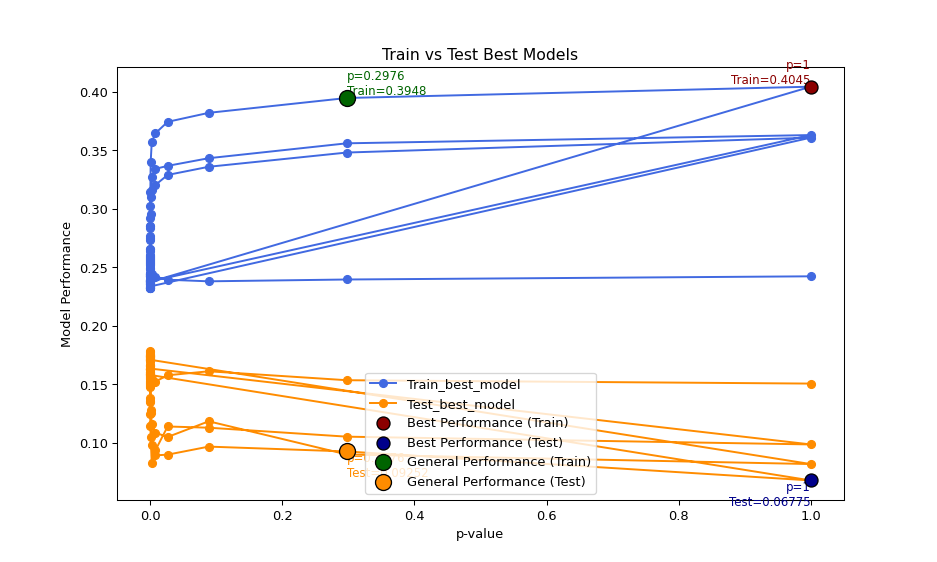

2. Reporting Generalized Performance:

|                  |            18 |
|:-----------------|--------------:|
| clump_p1         |   1           |
| clump_r2         |   0.1         |
| clump_kb         | 200           |
| p_window_size    | 200           |
| p_slide_size     |  50           |
| p_LD_threshold   |   0.25        |
| pvalue           |   0.297635    |
| window_shift     |   0           |
| numberofpca      |   6           |
| tempalpha        |   0.1         |
| l1weight         |   0.1         |
| Train_pure_prs   |  -1.02208e-05 |
| Train_null_model |   0.231715    |
| Train_best_model |   0.394802    |
| Test_pure_prs    |  -2.95153e-06 |
| Test_null_model  |   0.172422    |
| Test_best_model  |   0.0925211   |
| Difference       |   0.302281    |
| Sum              |   0.487323    |
3. Reporting the correlation of hyperparameters and the performance of 'Train_null_model', 'Train_pure_prs', 'Train_best_model', 'Test_pure_prs', 'Test_null_model', and 'Test_best_mode

<IPython.core.display.Javascript object>


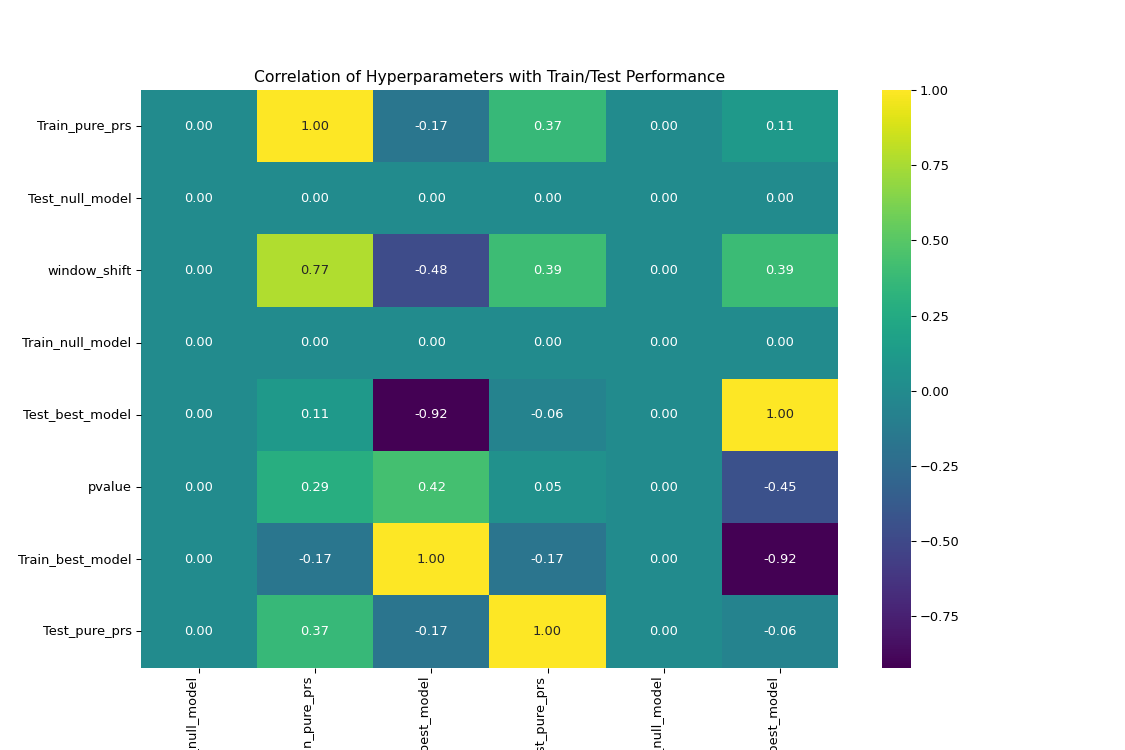

<IPython.core.display.Javascript object>


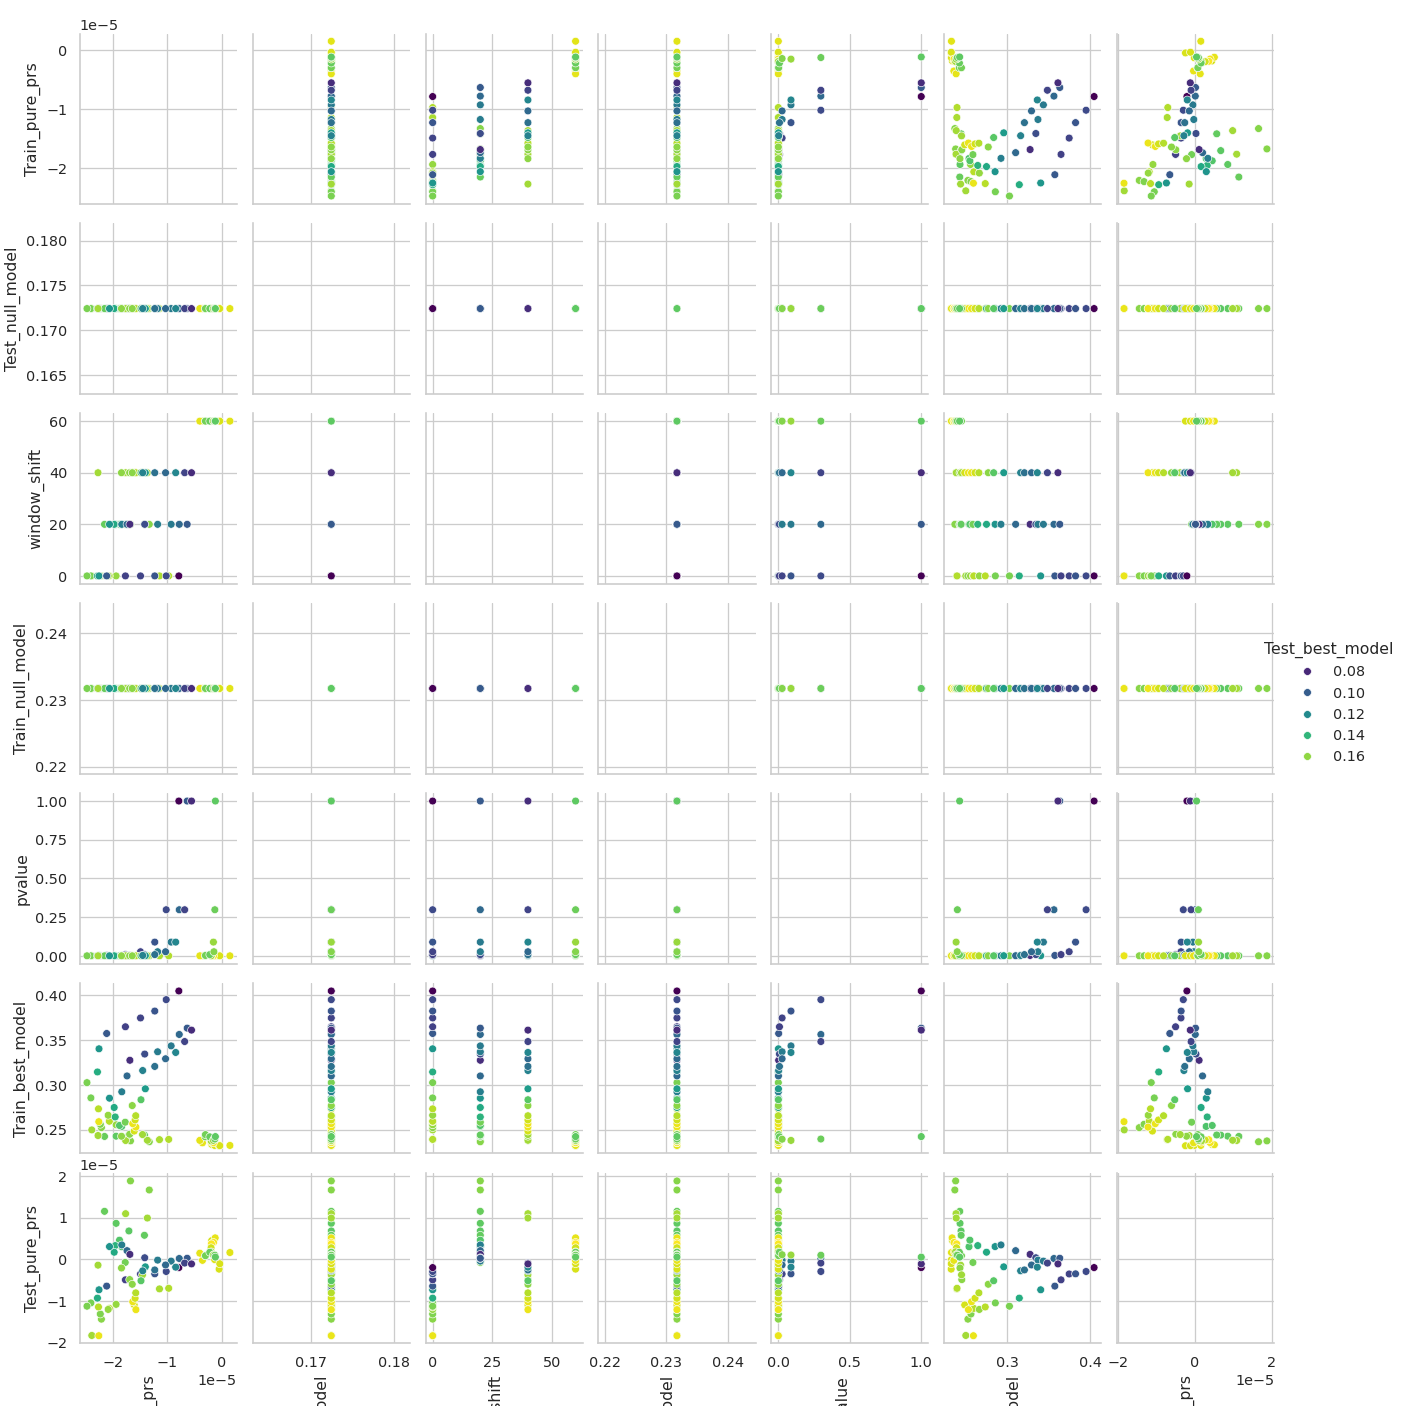

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

df = divided_result.sort_values(by='Train_best_model', ascending=False)
print("1. Reporting Based on Best Training Performance:\n")
print(df.iloc[0].to_markdown())


 
df = divided_result.copy()

# Plot Train and Test best models against p-values
plt.figure(figsize=(10, 6))
plt.plot(df['pvalue'], df['Train_best_model'], label='Train_best_model', marker='o', color='royalblue')
plt.plot(df['pvalue'], df['Test_best_model'], label='Test_best_model', marker='o', color='darkorange')

# Highlight the p-value where both train and test are high
best_index = df[['Train_best_model']].sum(axis=1).idxmax()
best_pvalue = df.loc[best_index, 'pvalue']
best_train = df.loc[best_index, 'Train_best_model']
best_test = df.loc[best_index, 'Test_best_model']

# Use dark colors for the circles
plt.scatter(best_pvalue, best_train, color='darkred', s=100, label=f'Best Performance (Train)', edgecolor='black', zorder=5)
plt.scatter(best_pvalue, best_test, color='darkblue', s=100, label=f'Best Performance (Test)', edgecolor='black', zorder=5)

# Annotate the best performance with p-value, train, and test values
plt.text(best_pvalue, best_train, f'p={best_pvalue:.4g}\nTrain={best_train:.4g}', ha='right', va='bottom', fontsize=9, color='darkred')
plt.text(best_pvalue, best_test, f'p={best_pvalue:.4g}\nTest={best_test:.4g}', ha='right', va='top', fontsize=9, color='darkblue')

# Calculate Difference and Sum
df['Difference'] = abs(df['Train_best_model'] - df['Test_best_model'])
df['Sum'] = df['Train_best_model'] + df['Test_best_model']

# Sort the DataFrame
sorted_df = df.sort_values(by=['Sum', 'Difference'], ascending=[False, True])
#sorted_df = df.sort_values(by=[ 'Difference','Sum'], ascending=[  True,False])

# Highlight the general performance
general_index = sorted_df.index[0]
general_pvalue = sorted_df.loc[general_index, 'pvalue']
general_train = sorted_df.loc[general_index, 'Train_best_model']
general_test = sorted_df.loc[general_index, 'Test_best_model']

plt.scatter(general_pvalue, general_train, color='darkgreen', s=150, label='General Performance (Train)', edgecolor='black', zorder=6)
plt.scatter(general_pvalue, general_test, color='darkorange', s=150, label='General Performance (Test)', edgecolor='black', zorder=6)

# Annotate the general performance with p-value, train, and test values
plt.text(general_pvalue, general_train, f'p={general_pvalue:.4g}\nTrain={general_train:.4g}', ha='left', va='bottom', fontsize=9, color='darkgreen')
plt.text(general_pvalue, general_test, f'p={general_pvalue:.4g}\nTest={general_test:.4g}', ha='left', va='top', fontsize=9, color='darkorange')

# Add labels and legend
plt.xlabel('p-value')
plt.ylabel('Model Performance')
plt.title('Train vs Test Best Models')
plt.legend()
plt.show()
 




print("2. Reporting Generalized Performance:\n")
df = divided_result.copy()
df['Difference'] = abs(df['Train_best_model'] - df['Test_best_model'])
df['Sum'] = df['Train_best_model'] + df['Test_best_model']
sorted_df = df.sort_values(by=['Sum', 'Difference'], ascending=[False, True])
print(sorted_df.iloc[0].to_markdown())


print("3. Reporting the correlation of hyperparameters and the performance of 'Train_null_model', 'Train_pure_prs', 'Train_best_model', 'Test_pure_prs', 'Test_null_model', and 'Test_best_model':\n")

print("3. For string hyperparameters, we used one-hot encoding to find the correlation between string hyperparameters and 'Train_null_model', 'Train_pure_prs', 'Train_best_model', 'Test_pure_prs', 'Test_null_model', and 'Test_best_model'.")

print("3. We performed this analysis for those hyperparameters that have more than one unique value.")

correlation_columns = [
 'Train_null_model', 'Train_pure_prs', 'Train_best_model',
 'Test_pure_prs', 'Test_null_model', 'Test_best_model'
]

hyperparams = [col for col in divided_result.columns if len(divided_result[col].unique()) > 1]
hyperparams = list(set(hyperparams+correlation_columns))
 
# Separate numeric and string columns
numeric_hyperparams = [col for col in hyperparams if pd.api.types.is_numeric_dtype(divided_result[col])]
string_hyperparams = [col for col in hyperparams if pd.api.types.is_string_dtype(divided_result[col])]


# Encode string columns using one-hot encoding
divided_result_encoded = pd.get_dummies(divided_result, columns=string_hyperparams)

# Combine numeric hyperparams with the new one-hot encoded columns
encoded_columns = [col for col in divided_result_encoded.columns if col.startswith(tuple(string_hyperparams))]
hyperparams = numeric_hyperparams + encoded_columns
 

# Calculate correlations
correlations = divided_result_encoded[hyperparams].corr()
 
# Display correlation of hyperparameters with train/test performance columns
hyperparam_correlations = correlations.loc[hyperparams, correlation_columns]
 
hyperparam_correlations = hyperparam_correlations.fillna(0)

# Plotting the correlation heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(hyperparam_correlations, annot=True, cmap='viridis', fmt='.2f', cbar=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

# Rotate y-axis labels to horizontal
#ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va='center')

plt.title('Correlation of Hyperparameters with Train/Test Performance')
plt.show() 

sns.set_theme(style="whitegrid")  # Choose your preferred style
pairplot = sns.pairplot(divided_result_encoded[hyperparams],hue = 'Test_best_model', palette='viridis')

# Adjust the figure size
pairplot.fig.set_size_inches(15, 15)  # You can adjust the size as needed

for ax in pairplot.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), rotation=90, ha='right')  # X-axis labels vertical
    #ax.set_ylabel(ax.get_ylabel(), rotation=0, va='bottom')  # Y-axis labels horizontal

# Show the plot
plt.show()




 
### Notes

This tool produced the following errors:
Kindly contact author:
Here are the names and email addresses:

1. **Chun, Sung Gook** - `<SungGook.Chun@childrens.harvard.edu>`
2. **nstitziel** - `<nstitziel@wustl.edu>`
3. **ssunyaev** - `<ssunyaev@rics.bwh.harvard.edu>`


```r
Error in family$linkfun(mustart) : 
  Argument mu must be a nonempty numeric vector
Calls: glm ... eval -> eval -> glm.fit -> %||% -> <Anonymous> -> .Call
Execution halted
```

```r
In max(abs(betahat.win.tailfix)[masked[begin:end] > 0]) :
  no non-missing arguments to max; returning -Inf
Error in lm.fit(x, y, offset = offset, singular.ok = singular.ok, ...) : 
  0 (non-NA) cases
Calls: lm -> lm.fit
Execution halted
```